## Загрузка данных и подключение библиотек

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-may-2021
!pip install catboost
!pip install eli5
!pip install optuna
!pip install shap
!pip install scikit-learn-extra
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip
!unzip /content/sample_submission.csv.zip

kaggle.json
  0% 0.00/851k [00:00<?, ?B/s]
100% 851k/851k [00:00<00:00, 55.9MB/s]
  0% 0.00/128k [00:00<?, ?B/s]
100% 128k/128k [00:00<00:00, 42.0MB/s]
  0% 0.00/1.72M [00:00<?, ?B/s]
100% 1.72M/1.72M [00:00<00:00, 117MB/s]
     |████████████████████████████████| 67.3MB 41kB/s 
     |████████████████████████████████| 112kB 8.4MB/s 
     |████████████████████████████████| 296kB 9.2MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 174kB 22.5MB/s 
     |████████████████████████████████| 143kB 34.7MB/s 
     |████████████████████████████████| 112kB 33.8MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=fd4376ad19fb315055a45f36646845bbfdbeb9a6c2ebd75defd08bd09f145bba
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully bu

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import catboost as cb
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, FactorAnalysis as FA
from typing import List, Optional
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from typing import List, Tuple
import scipy.stats as ss
from sklearn_extra.cluster import KMedoids
import math
from sklearn.utils.validation import check_is_fitted
import eli5
from sklearn.base import BaseEstimator, TransformerMixin
import time
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import shap
import missingno as msno
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
import optuna
from sklearn.metrics import log_loss
pd.plotting.register_matplotlib_converters()
%matplotlib inline
sns.set(color_codes=True)
pal = sns.color_palette("viridis", 10)
sns.set_palette(pal)

## Используемые функции

In [2]:
def get_input(data_path: str) -> pd.DataFrame:
  """
  Считывание данных и вывод основной информации о наборе данных.

  Parmeters
  ---------
  data_path: str - название файла

  Returns
  -------
  data: pandas.core.frame.DataFrame - загруженный набор данных в pandas.Dataframe
  """
  base_path = "/content"
  data = pd.read_csv(f"{base_path}/{data_path}")
  data.columns = [col.lower() for col in data.columns]
  print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
  return data

In [3]:
def plot_feature_importance(importance, names, model_type, figsize=(10,8)):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=figsize)
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  return list(fi_df['feature_names'].values)

In [4]:
def multi_estimators_predict(estimators: List,
                             x_valid: pd.DataFrame,
                             y_valid = None,
                             metric: callable = None,
                             scalers: List = None):
  preds = []
  evals = []
  if scalers:
    assert len(estimators) == len(scalers)

  for i in range(len(estimators)):
    if scalers:
      pred = estimators[i].predict_proba(scalers[i].transform(x_valid))
    else:
      if type(estimators[0]) == xgb.core.Booster:
        pred = estimators[i].predict(x_valid)
      else:
        pred = estimators[i].predict_proba(x_valid)

    
    preds.append(pred)
    if (y_valid is not None) and (metric is not None):
      eval = metric(y_valid, pred)
      evals.append(eval)
  
  result = np.stack([preds], axis=0)
  result = np.squeeze(result, axis=0)
  result = np.mean(result, axis=0)

  if (y_valid is not None) & (metric is not None):
    for i, eval in enumerate(evals):
      print(f"Model {i} metric: {eval:.7}")
    print(f"Result model metric: {metric(y_valid, result):.7}")

  return result

In [5]:
def logistic_cv_fit(params, X, y, cv, scale=False):
    """
    Кросс-валидация для модели LogisticRegression.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """

    estimators, folds_scores, scalers = [], [], []
    oof_preds = np.zeros((X.shape[0], 4))
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        if scale:
          scaler = StandardScaler()
          x_train = scaler.fit_transform(x_train)
          x_valid = scaler.transform(x_valid)
        model = LogisticRegression(**params)
        model.fit(x_train, y_train)
        oof_preds[valid_idx] = model.predict_proba(x_valid)
        score = metrics.log_loss(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
        if scale:
          scalers.append(scaler)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds, scalers

In [6]:
def catboost_cv_fit(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros((X.shape[0], 4))
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            #eval_set=[(x_valid, y_valid)], 
            verbose=10, 
            #early_stopping_rounds=100,
            #cat_features=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)
        score = metrics.log_loss(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [7]:
def lightgbm_cv_fit(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros((X.shape[0], 4))
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            #eval_set=[(x_valid, y_valid)],
            #eval_metric="multi_logloss", 
            verbose=10, 
            #early_stopping_rounds=50,
            #categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)
        score = metrics.log_loss(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [8]:
def xgboost_cv_fit(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели xgboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros((X.shape[0], 4))

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            #eval_set=[(x_valid, y_valid)],
            #eval_metric="mlogloss", 
            verbose=10, 
            #early_stopping_rounds=50,
        )

        oof_preds[valid_idx] = model.predict_proba(x_valid)
        score = metrics.log_loss(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

## Загрузка данных и построение моделей

### lightgbm + optuna

In [ ]:
def objective(trial):
    data = get_input("train.csv")
    data.drop(columns='id', inplace=True)
    mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
    data['target'] = data['target'].map(mapper)
    target = data['target']
    data = data.drop(columns=['target'])

    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.5)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)

    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        #"n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'num_class': 4,
        'max_depth': trial.suggest_int('max_depth', 3,7),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.05, 0.13),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    gbm = lgb.train(
        param, dtrain, 
        valid_sets=[dvalid], 
        verbose_eval=False, 
        callbacks=[pruning_callback]
    )

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)

    log_loss = sklearn.metrics.log_loss(valid_y, preds)
    return log_loss

In [ ]:
# Лучше подбирать гиперпараметры на всей data через кросс валидацию
import optuna.integration.lightgbm as lgb
def objective(trial):
    data = get_input("train.csv")
    data.drop(columns='id', inplace=True)
    mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
    data['target'] = data['target'].map(mapper)
    target = data['target']
    data = data.drop(columns=['target'])

    dtrain = lgb.Dataset(data, label=target)

    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'num_class': 4,

        'max_depth': trial.suggest_int('max_depth', 3,7),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.03, 0.13 ),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    result = lgb.cv(
      params=param,
      train_set=dtrain,
      num_boost_round=10000,
      early_stopping_rounds=100,
      #verbose_eval=10,
      stratified=True,
      seed=42,
      metrics="multi_logloss",
      shuffle=True,
      nfold=3
    )
 
    log_loss = result['multi_logloss-mean'][-1] + result['multi_logloss-stdv'][-1]
    return log_loss

In [ ]:
study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=20), direction="minimize"
    )
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

[I 2021-05-25 20:05:15,460] A new study created in memory with name: no-name-67bb9b06-6056-4c5f-9440-69bfd5220d67


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:06:07,912] Trial 0 finished with value: 1.095420663265998 and parameters: {'lambda_l1': 0.00024587192153438774, 'lambda_l2': 2.9664723207282242e-08, 'num_leaves': 223, 'feature_fraction': 0.7099892913219672, 'bagging_fraction': 0.7228809986014417, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 5, 'learning_rate': 0.08549446305776937}. Best is trial 0 with value: 1.095420663265998.


train.csv: shape = 100000 rows, 52 cols


KeyboardInterrupt: ignored

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
print(study.best_params)

{'lambda_l1': 1.45120566383297e-06, 'lambda_l2': 0.003368552965821498, 'num_leaves': 32, 'feature_fraction': 0.4471131328810426, 'bagging_fraction': 0.5888198372400193, 'bagging_freq': 4, 'min_child_samples': 32}


In [ ]:
study.best_value

1.0833801288748757

In [ ]:
data = get_input("train.csv")
data.drop(columns='id', inplace=True)
mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
data['target'] = data['target'].map(mapper)
target = data['target']
data = data.drop(columns=['target'])

lgb_params = {
    "boosting_type ": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    #'num_boost_round': 100,
    'num_class': 4,
    'lambda_l1': 0.02259438646302076,
    'lambda_l2': 3.3834082296901886e-05,
    'num_leaves': 256,
    'feature_fraction': 0.42939073275678896,
    'bagging_fraction': 0.8760623722003144,
    'bagging_freq': 4,
    'min_child_samples': 71,
    'max_depth': 4,
    'learning_rate': 0.07658957460133804,
}

dtrain = lgb.Dataset(data=data, label=target)

result = lgb.cv(
    params=lgb_params,
    train_set=dtrain,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="multi_logloss",
    shuffle=True,
    nfold=5
)

train.csv: shape = 100000 rows, 52 cols
[10]	cv_agg's multi_logloss: 1.11339 + 0.00019763
[20]	cv_agg's multi_logloss: 1.10998 + 0.000341567
[30]	cv_agg's multi_logloss: 1.10748 + 0.000399434
[40]	cv_agg's multi_logloss: 1.1054 + 0.000482044
[50]	cv_agg's multi_logloss: 1.10365 + 0.000591791
[60]	cv_agg's multi_logloss: 1.10218 + 0.000701451
[70]	cv_agg's multi_logloss: 1.10096 + 0.000759168
[80]	cv_agg's multi_logloss: 1.09988 + 0.000727296
[90]	cv_agg's multi_logloss: 1.09888 + 0.000727316
[100]	cv_agg's multi_logloss: 1.09803 + 0.000788178
[110]	cv_agg's multi_logloss: 1.09726 + 0.00084155
[120]	cv_agg's multi_logloss: 1.09667 + 0.000892679
[130]	cv_agg's multi_logloss: 1.09616 + 0.000970538
[140]	cv_agg's multi_logloss: 1.09569 + 0.00102404
[150]	cv_agg's multi_logloss: 1.09526 + 0.00106349
[160]	cv_agg's multi_logloss: 1.09494 + 0.0011131
[170]	cv_agg's multi_logloss: 1.09459 + 0.00114867
[180]	cv_agg's multi_logloss: 1.09433 + 0.00113994
[190]	cv_agg's multi_logloss: 1.09407 + 0.

In [ ]:
len(result['multi_logloss-mean'])

334

In [10]:
import lightgbm as lgb
data = get_input("train.csv")
test = get_input("test.csv")

data.drop(columns='id', inplace=True)
mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
data['target'] = data['target'].map(mapper)

target = data['target']
data = data.drop(columns=['target'])

#train, valid = train_test_split(
#    data, train_size=0.7, shuffle=True, random_state=1,
#)

#train.reset_index(inplace=True, drop=True)
#valid.reset_index(inplace=True, drop=True)

#y_train = train['target']
#x_train = train.drop(columns=['target'])
#y_valid = valid['target']
#x_valid = valid.drop(columns=['target'])

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols


In [26]:
lgb_params = {
    "boosting_type ": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    'n_estimators': 500,
    'num_class': 4,
    'lambda_l1': 0.02259438646302076,
    'lambda_l2': 3.3834082296901886e-05,
    'num_leaves': 256,
    'feature_fraction': 0.42939073275678896,
    'bagging_fraction': 0.8760623722003144,
    'bagging_freq': 4,
    'min_child_samples': 71,
    'max_depth': 3,
    'learning_rate': 0.07658957460133804,
    'random_state': 42,
}


lgb_params = {
    "boosting_type ": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    'n_estimators': 710,
    'num_class': 4,
    'lambda_l1': 0.02,
    'lambda_l2': 150,
    'num_leaves': 7,
    'feature_fraction': 0.11,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'min_child_samples': 80,
    'max_depth': 5,
    'learning_rate': 0.075,
    'random_state': 42,
    #'max_bin': 50,
    #'device' : 'gpu'
}


cv = StratifiedKFold(n_splits=15, random_state=435, shuffle=True)

lgb_estimators, lgb_oof = lightgbm_cv_fit(
    lgb_params, data.drop(columns=top_features[-1:]), target, cv, #categorical=categorical_feature_names
)

Mon May 31 18:08:17 2021, Cross-Validation, 100000 rows, 49 cols
Fold 1, Valid score = 1.09561
Fold 2, Valid score = 1.08849
Fold 3, Valid score = 1.0839
Fold 4, Valid score = 1.09231
Fold 5, Valid score = 1.08935
Fold 6, Valid score = 1.093
Fold 7, Valid score = 1.09345
Fold 8, Valid score = 1.08768
Fold 9, Valid score = 1.08866
Fold 10, Valid score = 1.09418
Fold 11, Valid score = 1.08995
Fold 12, Valid score = 1.09091
Fold 13, Valid score = 1.0915
Fold 14, Valid score = 1.08474
Fold 15, Valid score = 1.08703
Score by each fold: [1.09561, 1.08849, 1.0839, 1.09231, 1.08935, 1.093, 1.09345, 1.08768, 1.08866, 1.09418, 1.08995, 1.09091, 1.0915, 1.08474, 1.08703]


In [27]:
print(f"Out of fold log loss {metrics.log_loss(target, lgb_oof)}")

Out of fold log loss 1.0900506514638253


In [ ]:
lgb_estimators[0]

LGBMClassifier(bagging_fraction=0.8760623722003144, bagging_freq=4,
               boosting_type ='gbdt', feature_fraction=0.42939073275678896,
               lambda_l1=0.02259438646302076, lambda_l2=3.3834082296901886e-05,
               learning_rate=0.07658957460133804, max_depth=4,
               metric='multi_logloss', min_child_samples=71, n_estimators=334,
               num_class=4, num_leaves=256, objective='multiclass',
               random_state=42)

### Catboost

In [ ]:
# optuna с кросс валидацией работает очень долго поэтому первое приближение получим 
# на отложенной выборке а потом дотюним
def objective(trial):
    data = get_input("train.csv")
    data.drop(columns='id', inplace=True)
    mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
    data['target'] = data['target'].map(mapper)
    target = data['target']
    data = data.drop(columns=['target'])

    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.35)

    param = {
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "task_type": "GPU",
        
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        #"subsample": trial.suggest_float("subsample", 0.1, 1),

        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'depth': trial.suggest_int('depth', 3,7),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.13 ),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),                       
        #'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), # for bayesian bootstrap only

        #'bootstrap_type': 'Bernoulli',
        #'leaf_estimation_method': 'Newton',

        'grow_policy': "SymmetricTree",
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)
    preds = gbm.predict_proba(valid_x)


    log_loss = sklearn.metrics.log_loss(valid_y, preds)
    return log_loss

In [ ]:
study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=20), direction="minimize"
    )
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

[I 2021-05-25 20:07:18,768] A new study created in memory with name: no-name-234ea1e3-17bb-4364-985a-ec4112338ece


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:19,978] Trial 0 finished with value: 1.186633703881519 and parameters: {'min_data_in_leaf': 24, 'depth': 3, 'learning_rate': 0.12078519555155853, 'random_strength': 58, 'l2_leaf_reg': 2.6581884406103866e-06}. Best is trial 0 with value: 1.186633703881519.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:25,654] Trial 1 finished with value: 1.0898680635762144 and parameters: {'min_data_in_leaf': 33, 'depth': 4, 'learning_rate': 0.07195112205603399, 'random_strength': 86, 'l2_leaf_reg': 1.0362623676141234}. Best is trial 1 with value: 1.0898680635762144.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:26,936] Trial 2 finished with value: 1.3173342168736666 and parameters: {'min_data_in_leaf': 48, 'depth': 5, 'learning_rate': 0.12118267255718547, 'random_strength': 91, 'l2_leaf_reg': 2.187737122396502e-08}. Best is trial 1 with value: 1.0898680635762144.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:28,074] Trial 3 finished with value: 1.2885143238830576 and parameters: {'min_data_in_leaf': 31, 'depth': 3, 'learning_rate': 0.09696703499053426, 'random_strength': 37, 'l2_leaf_reg': 1.2406705861350582e-05}. Best is trial 1 with value: 1.0898680635762144.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:29,193] Trial 4 finished with value: 1.3487214925450937 and parameters: {'min_data_in_leaf': 54, 'depth': 3, 'learning_rate': 0.03290172667305659, 'random_strength': 27, 'l2_leaf_reg': 4.774231469146752e-06}. Best is trial 1 with value: 1.0898680635762144.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:37,878] Trial 5 finished with value: 1.0889162908317813 and parameters: {'min_data_in_leaf': 77, 'depth': 7, 'learning_rate': 0.029612677933852936, 'random_strength': 94, 'l2_leaf_reg': 0.00011373313536023518}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:39,281] Trial 6 finished with value: 1.302177859838092 and parameters: {'min_data_in_leaf': 24, 'depth': 6, 'learning_rate': 0.08058916149233035, 'random_strength': 93, 'l2_leaf_reg': 1.1370106091251025e-06}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:47,215] Trial 7 finished with value: 1.09778252116426 and parameters: {'min_data_in_leaf': 60, 'depth': 7, 'learning_rate': 0.019222503766012825, 'random_strength': 61, 'l2_leaf_reg': 6.0086680216965815}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:50,283] Trial 8 finished with value: 1.0949399281089018 and parameters: {'min_data_in_leaf': 79, 'depth': 6, 'learning_rate': 0.09010758048307221, 'random_strength': 42, 'l2_leaf_reg': 0.00031754537242025536}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:07:57,351] Trial 9 finished with value: 1.090675829555737 and parameters: {'min_data_in_leaf': 16, 'depth': 5, 'learning_rate': 0.022515184320922844, 'random_strength': 3, 'l2_leaf_reg': 0.007360147687425196}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:05,433] Trial 10 finished with value: 1.089795460988898 and parameters: {'min_data_in_leaf': 89, 'depth': 7, 'learning_rate': 0.05010642411806855, 'random_strength': 75, 'l2_leaf_reg': 0.0082235810452614}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:12,788] Trial 11 finished with value: 1.0940156528097917 and parameters: {'min_data_in_leaf': 100, 'depth': 7, 'learning_rate': 0.04243292265973676, 'random_strength': 74, 'l2_leaf_reg': 0.024042200708683355}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:18,801] Trial 12 finished with value: 1.0970233447213409 and parameters: {'min_data_in_leaf': 95, 'depth': 7, 'learning_rate': 0.04680601468804839, 'random_strength': 74, 'l2_leaf_reg': 0.00031147846915903304}. Best is trial 5 with value: 1.0889162908317813.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:25,122] Trial 13 finished with value: 1.0869168701293184 and parameters: {'min_data_in_leaf': 80, 'depth': 6, 'learning_rate': 0.05557664790258706, 'random_strength': 75, 'l2_leaf_reg': 0.17076216460834498}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:30,051] Trial 14 finished with value: 1.094574348718123 and parameters: {'min_data_in_leaf': 73, 'depth': 6, 'learning_rate': 0.060526678307841975, 'random_strength': 100, 'l2_leaf_reg': 0.2621555442458}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:35,964] Trial 15 finished with value: 1.0999934903965098 and parameters: {'min_data_in_leaf': 72, 'depth': 6, 'learning_rate': 0.014175811896680296, 'random_strength': 100, 'l2_leaf_reg': 0.19544945187028492}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:43,547] Trial 16 finished with value: 1.0951472922018242 and parameters: {'min_data_in_leaf': 88, 'depth': 6, 'learning_rate': 0.03164915071400415, 'random_strength': 81, 'l2_leaf_reg': 58.96772387736771}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:44,828] Trial 17 finished with value: 1.3498115755394768 and parameters: {'min_data_in_leaf': 64, 'depth': 5, 'learning_rate': 0.0620943623388789, 'random_strength': 66, 'l2_leaf_reg': 4.001607179131703e-08}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:46,475] Trial 18 finished with value: 1.3661173627100829 and parameters: {'min_data_in_leaf': 78, 'depth': 7, 'learning_rate': 0.03384338484436058, 'random_strength': 53, 'l2_leaf_reg': 5.9950172509526934e-05}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:52,099] Trial 19 finished with value: 1.0930752961393073 and parameters: {'min_data_in_leaf': 47, 'depth': 4, 'learning_rate': 0.059975321977370495, 'random_strength': 95, 'l2_leaf_reg': 46.21602942887901}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:08:58,461] Trial 20 finished with value: 1.0956206476692645 and parameters: {'min_data_in_leaf': 86, 'depth': 6, 'learning_rate': 0.0487189829246778, 'random_strength': 81, 'l2_leaf_reg': 0.0034420161371314434}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:04,271] Trial 21 finished with value: 1.0964208791848402 and parameters: {'min_data_in_leaf': 92, 'depth': 7, 'learning_rate': 0.05155988672844171, 'random_strength': 70, 'l2_leaf_reg': 0.05073263276454544}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:08,350] Trial 22 finished with value: 1.0943119874389708 and parameters: {'min_data_in_leaf': 100, 'depth': 7, 'learning_rate': 0.07363262492465013, 'random_strength': 81, 'l2_leaf_reg': 0.0014202170487802562}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:15,444] Trial 23 finished with value: 1.0942957978348875 and parameters: {'min_data_in_leaf': 81, 'depth': 7, 'learning_rate': 0.010415070300543172, 'random_strength': 46, 'l2_leaf_reg': 2.419516376036321}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:22,779] Trial 24 finished with value: 1.0945391816317032 and parameters: {'min_data_in_leaf': 68, 'depth': 6, 'learning_rate': 0.04093752837633574, 'random_strength': 87, 'l2_leaf_reg': 0.00011512520576207445}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:31,433] Trial 25 finished with value: 1.0911117665423764 and parameters: {'min_data_in_leaf': 85, 'depth': 7, 'learning_rate': 0.025349720673813872, 'random_strength': 66, 'l2_leaf_reg': 0.01531751738760251}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:36,758] Trial 26 finished with value: 1.0938253751049742 and parameters: {'min_data_in_leaf': 94, 'depth': 6, 'learning_rate': 0.0561982029135949, 'random_strength': 77, 'l2_leaf_reg': 0.13698238968659376}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:45,475] Trial 27 finished with value: 1.0948455760112155 and parameters: {'min_data_in_leaf': 73, 'depth': 7, 'learning_rate': 0.038374213706832555, 'random_strength': 97, 'l2_leaf_reg': 0.0034145043003224423}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:46,868] Trial 28 finished with value: 1.3390547462443718 and parameters: {'min_data_in_leaf': 100, 'depth': 6, 'learning_rate': 0.08153624038253171, 'random_strength': 54, 'l2_leaf_reg': 2.0857776634676497e-07}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:48,200] Trial 29 finished with value: 1.3230146482528375 and parameters: {'min_data_in_leaf': 59, 'depth': 5, 'learning_rate': 0.1104600254746971, 'random_strength': 59, 'l2_leaf_reg': 2.2118644783930476e-05}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:52,531] Trial 30 finished with value: 1.0909489404184392 and parameters: {'min_data_in_leaf': 82, 'depth': 7, 'learning_rate': 0.06751713804896142, 'random_strength': 87, 'l2_leaf_reg': 0.0008407576807235519}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:09:57,979] Trial 31 finished with value: 1.0947043377890044 and parameters: {'min_data_in_leaf': 12, 'depth': 4, 'learning_rate': 0.069968793451516, 'random_strength': 87, 'l2_leaf_reg': 1.4015505546670397}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:03,459] Trial 32 finished with value: 1.0962105962450035 and parameters: {'min_data_in_leaf': 35, 'depth': 4, 'learning_rate': 0.05327634231289161, 'random_strength': 90, 'l2_leaf_reg': 0.8421502382481408}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:09,109] Trial 33 finished with value: 1.0888008655046322 and parameters: {'min_data_in_leaf': 44, 'depth': 4, 'learning_rate': 0.08326139993190705, 'random_strength': 82, 'l2_leaf_reg': 4.38787365313175}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:14,757] Trial 34 finished with value: 1.0891163228015432 and parameters: {'min_data_in_leaf': 44, 'depth': 4, 'learning_rate': 0.07401870226859777, 'random_strength': 68, 'l2_leaf_reg': 4.806633786667923}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:19,640] Trial 35 finished with value: 1.0912007422677925 and parameters: {'min_data_in_leaf': 46, 'depth': 3, 'learning_rate': 0.10260585472884601, 'random_strength': 61, 'l2_leaf_reg': 7.1739537778928675}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:24,885] Trial 36 finished with value: 1.0911295965989822 and parameters: {'min_data_in_leaf': 40, 'depth': 4, 'learning_rate': 0.08362685593342127, 'random_strength': 68, 'l2_leaf_reg': 19.5016585222766}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:29,889] Trial 37 finished with value: 1.0904304174072934 and parameters: {'min_data_in_leaf': 52, 'depth': 3, 'learning_rate': 0.09195494513929797, 'random_strength': 82, 'l2_leaf_reg': 15.640398186875675}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:34,024] Trial 38 finished with value: 1.091773130108656 and parameters: {'min_data_in_leaf': 27, 'depth': 4, 'learning_rate': 0.10431303937438824, 'random_strength': 19, 'l2_leaf_reg': 3.6332782374751846}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:38,194] Trial 39 finished with value: 1.091337770913929 and parameters: {'min_data_in_leaf': 41, 'depth': 5, 'learning_rate': 0.07612992552539298, 'random_strength': 92, 'l2_leaf_reg': 0.6074548545386605}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:39,310] Trial 40 finished with value: 1.3333257841583332 and parameters: {'min_data_in_leaf': 57, 'depth': 3, 'learning_rate': 0.09234127933122296, 'random_strength': 71, 'l2_leaf_reg': 2.238766542613101e-06}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:44,434] Trial 41 finished with value: 1.0929482589286184 and parameters: {'min_data_in_leaf': 39, 'depth': 4, 'learning_rate': 0.06650573765708406, 'random_strength': 74, 'l2_leaf_reg': 0.05051148100289595}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:48,228] Trial 42 finished with value: 1.0908082906243195 and parameters: {'min_data_in_leaf': 51, 'depth': 5, 'learning_rate': 0.0857614907520053, 'random_strength': 78, 'l2_leaf_reg': 0.06481261077238604}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:52,727] Trial 43 finished with value: 1.0932308932274237 and parameters: {'min_data_in_leaf': 65, 'depth': 4, 'learning_rate': 0.07509229592790023, 'random_strength': 66, 'l2_leaf_reg': 0.42949053571331613}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:10:59,466] Trial 44 finished with value: 1.0963491112680257 and parameters: {'min_data_in_leaf': 44, 'depth': 5, 'learning_rate': 0.045194948716566735, 'random_strength': 84, 'l2_leaf_reg': 0.011286360562003087}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:05,233] Trial 45 finished with value: 1.0938743336946204 and parameters: {'min_data_in_leaf': 31, 'depth': 4, 'learning_rate': 0.05622817277750462, 'random_strength': 76, 'l2_leaf_reg': 0.0003416919361316871}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:10,182] Trial 46 finished with value: 1.0977939379999926 and parameters: {'min_data_in_leaf': 76, 'depth': 3, 'learning_rate': 0.06371232810186106, 'random_strength': 35, 'l2_leaf_reg': 11.574361044918115}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:16,221] Trial 47 finished with value: 1.0927217405839302 and parameters: {'min_data_in_leaf': 63, 'depth': 5, 'learning_rate': 0.025194031946044203, 'random_strength': 99, 'l2_leaf_reg': 0.1275162887245796}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:23,664] Trial 48 finished with value: 1.0908352270553296 and parameters: {'min_data_in_leaf': 91, 'depth': 6, 'learning_rate': 0.03158676067360349, 'random_strength': 62, 'l2_leaf_reg': 2.3115177796261444}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:24,844] Trial 49 finished with value: 1.3414319704950226 and parameters: {'min_data_in_leaf': 21, 'depth': 4, 'learning_rate': 0.07705141545329378, 'random_strength': 91, 'l2_leaf_reg': 1.904714694293859e-05}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:32,799] Trial 50 finished with value: 1.0955196981207298 and parameters: {'min_data_in_leaf': 70, 'depth': 7, 'learning_rate': 0.018005019541046767, 'random_strength': 55, 'l2_leaf_reg': 86.5270796898434}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:38,523] Trial 51 finished with value: 1.0925668709609466 and parameters: {'min_data_in_leaf': 37, 'depth': 4, 'learning_rate': 0.08894556221388104, 'random_strength': 72, 'l2_leaf_reg': 28.55045776692967}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:43,592] Trial 52 finished with value: 1.093101618666682 and parameters: {'min_data_in_leaf': 32, 'depth': 4, 'learning_rate': 0.0792330468382374, 'random_strength': 85, 'l2_leaf_reg': 0.33291861070436807}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:48,297] Trial 53 finished with value: 1.094209420501426 and parameters: {'min_data_in_leaf': 27, 'depth': 3, 'learning_rate': 0.0716504908066034, 'random_strength': 77, 'l2_leaf_reg': 5.749125573493157}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:11:54,043] Trial 54 finished with value: 1.0910771227398406 and parameters: {'min_data_in_leaf': 43, 'depth': 4, 'learning_rate': 0.05946901879295437, 'random_strength': 95, 'l2_leaf_reg': 1.056046119201111}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:00,238] Trial 55 finished with value: 1.0907661649818936 and parameters: {'min_data_in_leaf': 49, 'depth': 7, 'learning_rate': 0.05068452580691591, 'random_strength': 80, 'l2_leaf_reg': 0.0038380670062249478}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:06,111] Trial 56 finished with value: 1.0906496093277767 and parameters: {'min_data_in_leaf': 55, 'depth': 6, 'learning_rate': 0.06504868292651468, 'random_strength': 90, 'l2_leaf_reg': 0.029458167721213388}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:07,407] Trial 57 finished with value: 1.2889636681170535 and parameters: {'min_data_in_leaf': 84, 'depth': 5, 'learning_rate': 0.0963125667545601, 'random_strength': 49, 'l2_leaf_reg': 6.550951067368021e-05}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:14,460] Trial 58 finished with value: 1.097480017620552 and parameters: {'min_data_in_leaf': 90, 'depth': 7, 'learning_rate': 0.0362058499180881, 'random_strength': 65, 'l2_leaf_reg': 0.0009758517718541575}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:22,209] Trial 59 finished with value: 1.0901868917398791 and parameters: {'min_data_in_leaf': 76, 'depth': 6, 'learning_rate': 0.04357086163132811, 'random_strength': 84, 'l2_leaf_reg': 0.10809631346662618}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:25,491] Trial 60 finished with value: 1.0891165048346743 and parameters: {'min_data_in_leaf': 95, 'depth': 4, 'learning_rate': 0.1290658700086832, 'random_strength': 71, 'l2_leaf_reg': 1.9750289062057864}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:29,318] Trial 61 finished with value: 1.0927390977974325 and parameters: {'min_data_in_leaf': 98, 'depth': 4, 'learning_rate': 0.12476981590298908, 'random_strength': 70, 'l2_leaf_reg': 1.235256521569157}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:34,694] Trial 62 finished with value: 1.0982548974131083 and parameters: {'min_data_in_leaf': 88, 'depth': 4, 'learning_rate': 0.06962924012572276, 'random_strength': 74, 'l2_leaf_reg': 3.3813478451709313}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:37,644] Trial 63 finished with value: 1.0939610493515561 and parameters: {'min_data_in_leaf': 95, 'depth': 4, 'learning_rate': 0.1132028268260794, 'random_strength': 79, 'l2_leaf_reg': 0.3290636329583202}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:43,324] Trial 64 finished with value: 1.0947023360395058 and parameters: {'min_data_in_leaf': 81, 'depth': 4, 'learning_rate': 0.057556545694106176, 'random_strength': 88, 'l2_leaf_reg': 41.26139629102288}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:51,741] Trial 65 finished with value: 1.0944231780312432 and parameters: {'min_data_in_leaf': 35, 'depth': 7, 'learning_rate': 0.048117073540294195, 'random_strength': 96, 'l2_leaf_reg': 8.056741302291655}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:58,001] Trial 66 finished with value: 1.0932632524332595 and parameters: {'min_data_in_leaf': 97, 'depth': 5, 'learning_rate': 0.05434160408880501, 'random_strength': 63, 'l2_leaf_reg': 1.6419772439189682}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:12:59,219] Trial 67 finished with value: 1.3679190806644936 and parameters: {'min_data_in_leaf': 88, 'depth': 4, 'learning_rate': 0.030562506204571002, 'random_strength': 57, 'l2_leaf_reg': 0.00013410695950274917}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:02,892] Trial 68 finished with value: 1.088620023308173 and parameters: {'min_data_in_leaf': 46, 'depth': 3, 'learning_rate': 0.12922648720072863, 'random_strength': 68, 'l2_leaf_reg': 0.660823146060707}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:06,658] Trial 69 finished with value: 1.0935420244713856 and parameters: {'min_data_in_leaf': 47, 'depth': 3, 'learning_rate': 0.11977697187009476, 'random_strength': 69, 'l2_leaf_reg': 0.1870729374831878}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:10,024] Trial 70 finished with value: 1.0991958452135608 and parameters: {'min_data_in_leaf': 50, 'depth': 3, 'learning_rate': 0.1266918796276117, 'random_strength': 73, 'l2_leaf_reg': 0.005355801319274543}. Best is trial 13 with value: 1.0869168701293184.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:14,001] Trial 71 finished with value: 1.085815400126414 and parameters: {'min_data_in_leaf': 44, 'depth': 4, 'learning_rate': 0.1174584342278517, 'random_strength': 76, 'l2_leaf_reg': 5.305749568383563}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:18,158] Trial 72 finished with value: 1.0997956750584494 and parameters: {'min_data_in_leaf': 54, 'depth': 3, 'learning_rate': 0.11768932718054712, 'random_strength': 75, 'l2_leaf_reg': 4.113717754340627}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:21,364] Trial 73 finished with value: 1.0904998476981853 and parameters: {'min_data_in_leaf': 45, 'depth': 5, 'learning_rate': 0.12402370799457353, 'random_strength': 67, 'l2_leaf_reg': 0.6432882712545613}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:26,025] Trial 74 finished with value: 1.0921964647726978 and parameters: {'min_data_in_leaf': 41, 'depth': 4, 'learning_rate': 0.12853826069104687, 'random_strength': 82, 'l2_leaf_reg': 22.129601025987316}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:29,796] Trial 75 finished with value: 1.0952290868789702 and parameters: {'min_data_in_leaf': 38, 'depth': 3, 'learning_rate': 0.12917417318308558, 'random_strength': 70, 'l2_leaf_reg': 0.0019526266380516548}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:32,996] Trial 76 finished with value: 1.0951099233649884 and parameters: {'min_data_in_leaf': 84, 'depth': 7, 'learning_rate': 0.11635157923576202, 'random_strength': 59, 'l2_leaf_reg': 0.02365253391092147}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:40,767] Trial 77 finished with value: 1.087209637219368 and parameters: {'min_data_in_leaf': 42, 'depth': 6, 'learning_rate': 0.03978145245111596, 'random_strength': 78, 'l2_leaf_reg': 7.946020629316243}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:48,577] Trial 78 finished with value: 1.091510055436855 and parameters: {'min_data_in_leaf': 43, 'depth': 6, 'learning_rate': 0.04035488067564389, 'random_strength': 63, 'l2_leaf_reg': 10.489822621565192}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:13:54,861] Trial 79 finished with value: 1.0889566945271378 and parameters: {'min_data_in_leaf': 48, 'depth': 5, 'learning_rate': 0.027409671872676806, 'random_strength': 83, 'l2_leaf_reg': 2.201260901268027}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:01,880] Trial 80 finished with value: 1.0941020114061375 and parameters: {'min_data_in_leaf': 52, 'depth': 6, 'learning_rate': 0.02858611363160938, 'random_strength': 82, 'l2_leaf_reg': 6.004192388769487}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:07,881] Trial 81 finished with value: 1.0915738575100467 and parameters: {'min_data_in_leaf': 47, 'depth': 5, 'learning_rate': 0.023419341355692923, 'random_strength': 78, 'l2_leaf_reg': 69.20635165692036}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:14,231] Trial 82 finished with value: 1.1028438728884988 and parameters: {'min_data_in_leaf': 57, 'depth': 6, 'learning_rate': 0.014479894342148358, 'random_strength': 84, 'l2_leaf_reg': 2.8721171904909784}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:20,188] Trial 83 finished with value: 1.089497266892655 and parameters: {'min_data_in_leaf': 41, 'depth': 5, 'learning_rate': 0.01977189834763539, 'random_strength': 72, 'l2_leaf_reg': 1.9023607102167628}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:25,658] Trial 84 finished with value: 1.0953998261240931 and parameters: {'min_data_in_leaf': 35, 'depth': 4, 'learning_rate': 0.03422194144160972, 'random_strength': 77, 'l2_leaf_reg': 0.5884839707979983}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:32,042] Trial 85 finished with value: 1.092804993412369 and parameters: {'min_data_in_leaf': 48, 'depth': 5, 'learning_rate': 0.03844845374270974, 'random_strength': 89, 'l2_leaf_reg': 13.559755787542654}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:37,305] Trial 86 finished with value: 1.0899799788880349 and parameters: {'min_data_in_leaf': 60, 'depth': 4, 'learning_rate': 0.02652441411996351, 'random_strength': 80, 'l2_leaf_reg': 30.220319116678656}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:38,549] Trial 87 finished with value: 1.2685851446855785 and parameters: {'min_data_in_leaf': 44, 'depth': 5, 'learning_rate': 0.1219338042651884, 'random_strength': 65, 'l2_leaf_reg': 7.963969844134074e-06}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:42,277] Trial 88 finished with value: 1.0943803495214046 and parameters: {'min_data_in_leaf': 50, 'depth': 4, 'learning_rate': 0.10463847684883673, 'random_strength': 93, 'l2_leaf_reg': 1.0703753757114405}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:46,248] Trial 89 finished with value: 1.091610834004211 and parameters: {'min_data_in_leaf': 37, 'depth': 4, 'learning_rate': 0.10816870227650681, 'random_strength': 75, 'l2_leaf_reg': 4.470818400643836}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:52,633] Trial 90 finished with value: 1.0993251958680852 and parameters: {'min_data_in_leaf': 53, 'depth': 6, 'learning_rate': 0.018464620025411174, 'random_strength': 86, 'l2_leaf_reg': 2.02533810734445}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:14:58,821] Trial 91 finished with value: 1.0909038350333593 and parameters: {'min_data_in_leaf': 41, 'depth': 5, 'learning_rate': 0.022461243188944185, 'random_strength': 72, 'l2_leaf_reg': 1.7470879843985108}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:04,591] Trial 92 finished with value: 1.1053396830474258 and parameters: {'min_data_in_leaf': 43, 'depth': 5, 'learning_rate': 0.013055562744416386, 'random_strength': 69, 'l2_leaf_reg': 8.011220841628457}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:10,994] Trial 93 finished with value: 1.0959840212092649 and parameters: {'min_data_in_leaf': 46, 'depth': 5, 'learning_rate': 0.03539095763911888, 'random_strength': 72, 'l2_leaf_reg': 0.4993260539831106}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:17,239] Trial 94 finished with value: 1.0922203333054845 and parameters: {'min_data_in_leaf': 39, 'depth': 5, 'learning_rate': 0.020661358506009662, 'random_strength': 76, 'l2_leaf_reg': 2.753881007129451}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:23,945] Trial 95 finished with value: 1.0952256583572633 and parameters: {'min_data_in_leaf': 49, 'depth': 6, 'learning_rate': 0.01649811390755066, 'random_strength': 79, 'l2_leaf_reg': 16.621968662835737}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:29,208] Trial 96 finished with value: 1.0938920474055016 and parameters: {'min_data_in_leaf': 34, 'depth': 4, 'learning_rate': 0.026491078225256696, 'random_strength': 83, 'l2_leaf_reg': 0.20897630724209273}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:35,698] Trial 97 finished with value: 1.0940918569206988 and parameters: {'min_data_in_leaf': 29, 'depth': 5, 'learning_rate': 0.031293034867445446, 'random_strength': 68, 'l2_leaf_reg': 0.9127224172194199}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:40,633] Trial 98 finished with value: 1.0914719192017377 and parameters: {'min_data_in_leaf': 40, 'depth': 4, 'learning_rate': 0.08498057231413021, 'random_strength': 1, 'l2_leaf_reg': 5.044462866108157}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:45,883] Trial 99 finished with value: 1.0881271305456548 and parameters: {'min_data_in_leaf': 56, 'depth': 5, 'learning_rate': 0.06206412568952399, 'random_strength': 64, 'l2_leaf_reg': 0.0005818823050644166}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:50,840] Trial 100 finished with value: 1.0963674059895554 and parameters: {'min_data_in_leaf': 67, 'depth': 3, 'learning_rate': 0.0682530801266307, 'random_strength': 57, 'l2_leaf_reg': 0.0003657178750560515}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:15:56,082] Trial 101 finished with value: 1.087810101532721 and parameters: {'min_data_in_leaf': 42, 'depth': 5, 'learning_rate': 0.06289041055953823, 'random_strength': 65, 'l2_leaf_reg': 0.0005788197793181886}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:00,438] Trial 102 finished with value: 1.0970001265711606 and parameters: {'min_data_in_leaf': 45, 'depth': 5, 'learning_rate': 0.06367350315501542, 'random_strength': 61, 'l2_leaf_reg': 0.00012759443602834142}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:04,746] Trial 103 finished with value: 1.0941351705221842 and parameters: {'min_data_in_leaf': 43, 'depth': 5, 'learning_rate': 0.07280061128717341, 'random_strength': 67, 'l2_leaf_reg': 0.0007062968331914221}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:09,954] Trial 104 finished with value: 1.0968565045271266 and parameters: {'min_data_in_leaf': 56, 'depth': 5, 'learning_rate': 0.061362047110361084, 'random_strength': 63, 'l2_leaf_reg': 5.353185983591124e-05}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:14,769] Trial 105 finished with value: 1.0917474665799758 and parameters: {'min_data_in_leaf': 61, 'depth': 6, 'learning_rate': 0.05882061585419245, 'random_strength': 74, 'l2_leaf_reg': 0.00020782700997358001}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:20,353] Trial 106 finished with value: 1.0957574441161775 and parameters: {'min_data_in_leaf': 71, 'depth': 4, 'learning_rate': 0.0531942897206421, 'random_strength': 70, 'l2_leaf_reg': 0.0019731253844117507}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:27,110] Trial 107 finished with value: 1.0916225839707163 and parameters: {'min_data_in_leaf': 37, 'depth': 5, 'learning_rate': 0.04637642173661336, 'random_strength': 80, 'l2_leaf_reg': 10.372122885941156}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:31,138] Trial 108 finished with value: 1.0957986233573647 and parameters: {'min_data_in_leaf': 93, 'depth': 5, 'learning_rate': 0.07759334364943074, 'random_strength': 52, 'l2_leaf_reg': 0.0007050725905880832}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:32,356] Trial 109 finished with value: 1.339598173194566 and parameters: {'min_data_in_leaf': 46, 'depth': 4, 'learning_rate': 0.0805525814605741, 'random_strength': 65, 'l2_leaf_reg': 7.81065446342873e-05}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:37,403] Trial 110 finished with value: 1.0868052071074006 and parameters: {'min_data_in_leaf': 74, 'depth': 4, 'learning_rate': 0.07167721344043389, 'random_strength': 76, 'l2_leaf_reg': 0.00027965608840102986}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:42,188] Trial 111 finished with value: 1.098530668863811 and parameters: {'min_data_in_leaf': 76, 'depth': 4, 'learning_rate': 0.06528958750178221, 'random_strength': 78, 'l2_leaf_reg': 0.00039237840131594296}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:46,836] Trial 112 finished with value: 1.0953331650159943 and parameters: {'min_data_in_leaf': 79, 'depth': 4, 'learning_rate': 0.0705899991886763, 'random_strength': 74, 'l2_leaf_reg': 0.00022121994914300086}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:51,380] Trial 113 finished with value: 1.0943410161819827 and parameters: {'min_data_in_leaf': 79, 'depth': 4, 'learning_rate': 0.06374847843160045, 'random_strength': 76, 'l2_leaf_reg': 0.0006588800784618913}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:52,598] Trial 114 finished with value: 1.2779946755393423 and parameters: {'min_data_in_leaf': 75, 'depth': 4, 'learning_rate': 0.0743931279799813, 'random_strength': 71, 'l2_leaf_reg': 2.0569845811055095e-05}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:57,366] Trial 115 finished with value: 1.0949878043155232 and parameters: {'min_data_in_leaf': 74, 'depth': 4, 'learning_rate': 0.06741102778301719, 'random_strength': 59, 'l2_leaf_reg': 0.0018038319222565236}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:16:58,480] Trial 116 finished with value: 1.3535184076302922 and parameters: {'min_data_in_leaf': 51, 'depth': 3, 'learning_rate': 0.05600259830641588, 'random_strength': 67, 'l2_leaf_reg': 5.15833731272787e-05}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:02,934] Trial 117 finished with value: 1.0920244228048288 and parameters: {'min_data_in_leaf': 42, 'depth': 6, 'learning_rate': 0.061936990501191246, 'random_strength': 86, 'l2_leaf_reg': 0.0012277423066983405}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:08,362] Trial 118 finished with value: 1.0883840283241315 and parameters: {'min_data_in_leaf': 49, 'depth': 4, 'learning_rate': 0.04378117649773524, 'random_strength': 81, 'l2_leaf_reg': 0.0002501690063546472}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:15,148] Trial 119 finished with value: 1.093278624082187 and parameters: {'min_data_in_leaf': 54, 'depth': 5, 'learning_rate': 0.04204059279674974, 'random_strength': 83, 'l2_leaf_reg': 0.00048322061986977923}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:20,743] Trial 120 finished with value: 1.0916459995877323 and parameters: {'min_data_in_leaf': 82, 'depth': 4, 'learning_rate': 0.05089286057250381, 'random_strength': 81, 'l2_leaf_reg': 0.000231112436499772}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:21,981] Trial 121 finished with value: 1.344824214349678 and parameters: {'min_data_in_leaf': 48, 'depth': 4, 'learning_rate': 0.036810265206777146, 'random_strength': 77, 'l2_leaf_reg': 3.939946217652258e-05}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:23,200] Trial 122 finished with value: 1.3576199109543132 and parameters: {'min_data_in_leaf': 45, 'depth': 4, 'learning_rate': 0.048254286512146666, 'random_strength': 73, 'l2_leaf_reg': 0.00015494357933893536}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:24,407] Trial 123 finished with value: 1.368933826105342 and parameters: {'min_data_in_leaf': 49, 'depth': 4, 'learning_rate': 0.029161807088689488, 'random_strength': 98, 'l2_leaf_reg': 2.9440029789773278e-05}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:30,340] Trial 124 finished with value: 1.0903592267043676 and parameters: {'min_data_in_leaf': 52, 'depth': 4, 'learning_rate': 0.04338331747128379, 'random_strength': 9, 'l2_leaf_reg': 3.7678946011597247}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:31,602] Trial 125 finished with value: 1.2268306237961406 and parameters: {'min_data_in_leaf': 47, 'depth': 4, 'learning_rate': 0.12988066603122203, 'random_strength': 88, 'l2_leaf_reg': 0.00011109974921444808}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:35,098] Trial 126 finished with value: 1.0925971909418013 and parameters: {'min_data_in_leaf': 45, 'depth': 7, 'learning_rate': 0.12641813524113574, 'random_strength': 69, 'l2_leaf_reg': 1.3260416869613578}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:39,793] Trial 127 finished with value: 1.098185042939332 and parameters: {'min_data_in_leaf': 69, 'depth': 5, 'learning_rate': 0.08816677135387892, 'random_strength': 65, 'l2_leaf_reg': 43.065946134716995}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:45,559] Trial 128 finished with value: 1.0970039982478146 and parameters: {'min_data_in_leaf': 72, 'depth': 4, 'learning_rate': 0.03943190598465972, 'random_strength': 80, 'l2_leaf_reg': 0.0032265513439438394}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:51,110] Trial 129 finished with value: 1.09793928215759 and parameters: {'min_data_in_leaf': 39, 'depth': 4, 'learning_rate': 0.05974093549637181, 'random_strength': 75, 'l2_leaf_reg': 6.9947373037583045}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:17:55,513] Trial 130 finished with value: 1.0956198494845795 and parameters: {'min_data_in_leaf': 66, 'depth': 5, 'learning_rate': 0.08246006758953621, 'random_strength': 71, 'l2_leaf_reg': 0.36417064282469175}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:00,890] Trial 131 finished with value: 1.1053900487988433 and parameters: {'min_data_in_leaf': 42, 'depth': 5, 'learning_rate': 0.010899287850710856, 'random_strength': 72, 'l2_leaf_reg': 1.7601557540588808}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:06,973] Trial 132 finished with value: 1.0947611860734456 and parameters: {'min_data_in_leaf': 41, 'depth': 5, 'learning_rate': 0.02129232590102709, 'random_strength': 78, 'l2_leaf_reg': 2.206288959751444}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:12,994] Trial 133 finished with value: 1.094178171759654 and parameters: {'min_data_in_leaf': 36, 'depth': 5, 'learning_rate': 0.023636079776076274, 'random_strength': 85, 'l2_leaf_reg': 0.8822119446722704}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:19,447] Trial 134 finished with value: 1.096307552433665 and parameters: {'min_data_in_leaf': 44, 'depth': 5, 'learning_rate': 0.02847974299872537, 'random_strength': 94, 'l2_leaf_reg': 3.232344340094915}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:25,195] Trial 135 finished with value: 1.0979648741001429 and parameters: {'min_data_in_leaf': 39, 'depth': 5, 'learning_rate': 0.09569152375592074, 'random_strength': 68, 'l2_leaf_reg': 23.974691744545613}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:30,869] Trial 136 finished with value: 1.0962936939671732 and parameters: {'min_data_in_leaf': 47, 'depth': 6, 'learning_rate': 0.06920054352094106, 'random_strength': 43, 'l2_leaf_reg': 5.810828377558208}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:36,303] Trial 137 finished with value: 1.0972376085519622 and parameters: {'min_data_in_leaf': 50, 'depth': 4, 'learning_rate': 0.032941711977609055, 'random_strength': 76, 'l2_leaf_reg': 0.0005185088237659192}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:42,683] Trial 138 finished with value: 1.092417259877358 and parameters: {'min_data_in_leaf': 42, 'depth': 5, 'learning_rate': 0.05476820847878669, 'random_strength': 61, 'l2_leaf_reg': 0.7557025003196809}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:47,411] Trial 139 finished with value: 1.0911198407488274 and parameters: {'min_data_in_leaf': 62, 'depth': 3, 'learning_rate': 0.0775506654643927, 'random_strength': 73, 'l2_leaf_reg': 13.639790096000116}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:51,883] Trial 140 finished with value: 1.0886253447676029 and parameters: {'min_data_in_leaf': 44, 'depth': 5, 'learning_rate': 0.07175348801715174, 'random_strength': 64, 'l2_leaf_reg': 0.0002922122904403586}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:18:56,744] Trial 141 finished with value: 1.094332267712891 and parameters: {'min_data_in_leaf': 44, 'depth': 5, 'learning_rate': 0.07144744202257229, 'random_strength': 63, 'l2_leaf_reg': 0.0012153095073154066}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:00,640] Trial 142 finished with value: 1.0944016421352016 and parameters: {'min_data_in_leaf': 86, 'depth': 5, 'learning_rate': 0.07557885884736826, 'random_strength': 64, 'l2_leaf_reg': 0.00026242148560125884}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:05,510] Trial 143 finished with value: 1.0968434353588759 and parameters: {'min_data_in_leaf': 40, 'depth': 5, 'learning_rate': 0.065879501204713, 'random_strength': 67, 'l2_leaf_reg': 0.0001053747450875934}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:11,545] Trial 144 finished with value: 1.0950806566400613 and parameters: {'min_data_in_leaf': 46, 'depth': 5, 'learning_rate': 0.044770534140768085, 'random_strength': 82, 'l2_leaf_reg': 0.0003047543710502623}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:16,671] Trial 145 finished with value: 1.0876127951654182 and parameters: {'min_data_in_leaf': 49, 'depth': 4, 'learning_rate': 0.0729207064984981, 'random_strength': 70, 'l2_leaf_reg': 0.000174075549524529}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:21,063] Trial 146 finished with value: 1.0973944818992203 and parameters: {'min_data_in_leaf': 48, 'depth': 4, 'learning_rate': 0.0732027419117292, 'random_strength': 61, 'l2_leaf_reg': 0.0009341611420668118}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:26,329] Trial 147 finished with value: 1.0916033337241229 and parameters: {'min_data_in_leaf': 51, 'depth': 4, 'learning_rate': 0.06854090362690525, 'random_strength': 79, 'l2_leaf_reg': 0.00019584855564888206}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:32,100] Trial 148 finished with value: 1.0905750727512733 and parameters: {'min_data_in_leaf': 54, 'depth': 4, 'learning_rate': 0.05744808904006431, 'random_strength': 70, 'l2_leaf_reg': 7.878501911013809e-05}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:37,143] Trial 149 finished with value: 1.0911456048862536 and parameters: {'min_data_in_leaf': 57, 'depth': 4, 'learning_rate': 0.06379650075554484, 'random_strength': 74, 'l2_leaf_reg': 0.0005264370749679039}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:41,556] Trial 150 finished with value: 1.0911800971898242 and parameters: {'min_data_in_leaf': 49, 'depth': 4, 'learning_rate': 0.07202423906086558, 'random_strength': 55, 'l2_leaf_reg': 0.0003133174531328408}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:47,369] Trial 151 finished with value: 1.0892752320943926 and parameters: {'min_data_in_leaf': 43, 'depth': 5, 'learning_rate': 0.06654414756871117, 'random_strength': 66, 'l2_leaf_reg': 1.4482568875840014}. Best is trial 71 with value: 1.085815400126414.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:52,817] Trial 152 finished with value: 1.0836613774733865 and parameters: {'min_data_in_leaf': 43, 'depth': 5, 'learning_rate': 0.07928546561861827, 'random_strength': 66, 'l2_leaf_reg': 2.9448952422509165}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:19:58,493] Trial 153 finished with value: 1.0925303009172498 and parameters: {'min_data_in_leaf': 46, 'depth': 4, 'learning_rate': 0.07583090786077903, 'random_strength': 69, 'l2_leaf_reg': 3.6605917401671424}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:03,564] Trial 154 finished with value: 1.0931811557868294 and parameters: {'min_data_in_leaf': 44, 'depth': 4, 'learning_rate': 0.0809056975074222, 'random_strength': 65, 'l2_leaf_reg': 9.30305500086425}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:08,829] Trial 155 finished with value: 1.0884331904672047 and parameters: {'min_data_in_leaf': 38, 'depth': 5, 'learning_rate': 0.07847590518639788, 'random_strength': 71, 'l2_leaf_reg': 5.141961854490971}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:14,463] Trial 156 finished with value: 1.09120276868818 and parameters: {'min_data_in_leaf': 78, 'depth': 5, 'learning_rate': 0.07891166914785935, 'random_strength': 76, 'l2_leaf_reg': 5.749057669735482}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:17,945] Trial 157 finished with value: 1.0946773542602186 and parameters: {'min_data_in_leaf': 38, 'depth': 5, 'learning_rate': 0.0839821258284749, 'random_strength': 58, 'l2_leaf_reg': 0.00016321627785227926}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:23,970] Trial 158 finished with value: 1.0860983521044218 and parameters: {'min_data_in_leaf': 33, 'depth': 5, 'learning_rate': 0.07347812110702893, 'random_strength': 91, 'l2_leaf_reg': 16.883797375955126}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:25,233] Trial 159 finished with value: 1.3427316910094496 and parameters: {'min_data_in_leaf': 33, 'depth': 5, 'learning_rate': 0.07449700348173086, 'random_strength': 91, 'l2_leaf_reg': 1.0562082189920065e-08}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:31,443] Trial 160 finished with value: 1.0914868780332525 and parameters: {'min_data_in_leaf': 33, 'depth': 5, 'learning_rate': 0.06931527087933374, 'random_strength': 88, 'l2_leaf_reg': 16.246299643009486}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:36,229] Trial 161 finished with value: 1.0969656222716007 and parameters: {'min_data_in_leaf': 36, 'depth': 5, 'learning_rate': 0.0784015761043092, 'random_strength': 96, 'l2_leaf_reg': 3.066859160764524}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:42,774] Trial 162 finished with value: 1.0927371561348818 and parameters: {'min_data_in_leaf': 29, 'depth': 5, 'learning_rate': 0.07308865172849306, 'random_strength': 84, 'l2_leaf_reg': 10.731602217108986}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:48,766] Trial 163 finished with value: 1.0950689701609597 and parameters: {'min_data_in_leaf': 41, 'depth': 5, 'learning_rate': 0.08007344886912093, 'random_strength': 68, 'l2_leaf_reg': 31.539222581225758}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:55,697] Trial 164 finished with value: 1.094803781637367 and parameters: {'min_data_in_leaf': 39, 'depth': 5, 'learning_rate': 0.07080127143177703, 'random_strength': 92, 'l2_leaf_reg': 92.86810000965558}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:20:57,127] Trial 165 finished with value: 1.307830224735433 and parameters: {'min_data_in_leaf': 81, 'depth': 6, 'learning_rate': 0.07443527325712612, 'random_strength': 71, 'l2_leaf_reg': 9.451890499623605e-05}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:02,351] Trial 166 finished with value: 1.0927788852941025 and parameters: {'min_data_in_leaf': 22, 'depth': 7, 'learning_rate': 0.07619682094336923, 'random_strength': 78, 'l2_leaf_reg': 5.068860466048079}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:06,379] Trial 167 finished with value: 1.0956905364566403 and parameters: {'min_data_in_leaf': 43, 'depth': 5, 'learning_rate': 0.08665584902813231, 'random_strength': 81, 'l2_leaf_reg': 0.00048344733448623533}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:13,186] Trial 168 finished with value: 1.0918583184206658 and parameters: {'min_data_in_leaf': 77, 'depth': 5, 'learning_rate': 0.08195379883886662, 'random_strength': 74, 'l2_leaf_reg': 7.725354972232793}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:17,926] Trial 169 finished with value: 1.0934594453245696 and parameters: {'min_data_in_leaf': 47, 'depth': 5, 'learning_rate': 0.06144564864172882, 'random_strength': 100, 'l2_leaf_reg': 0.0008598123817229146}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:23,265] Trial 170 finished with value: 1.0884463311523356 and parameters: {'min_data_in_leaf': 30, 'depth': 5, 'learning_rate': 0.05202379307279266, 'random_strength': 62, 'l2_leaf_reg': 0.0001637321158679474}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:28,265] Trial 171 finished with value: 1.093438530761892 and parameters: {'min_data_in_leaf': 29, 'depth': 5, 'learning_rate': 0.05097733539992173, 'random_strength': 61, 'l2_leaf_reg': 0.00021438786453292533}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:33,908] Trial 172 finished with value: 1.0974895080548814 and parameters: {'min_data_in_leaf': 31, 'depth': 5, 'learning_rate': 0.05296999817031669, 'random_strength': 64, 'l2_leaf_reg': 0.00033861458617426}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:35,313] Trial 173 finished with value: 1.2728932019424979 and parameters: {'min_data_in_leaf': 26, 'depth': 5, 'learning_rate': 0.0488520655152174, 'random_strength': 67, 'l2_leaf_reg': 5.5914832214997816e-05}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:40,822] Trial 174 finished with value: 1.0930689323610159 and parameters: {'min_data_in_leaf': 42, 'depth': 5, 'learning_rate': 0.0587908312619906, 'random_strength': 62, 'l2_leaf_reg': 0.00014159875100269414}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:42,163] Trial 175 finished with value: 1.3444021405401412 and parameters: {'min_data_in_leaf': 45, 'depth': 5, 'learning_rate': 0.07182208750868814, 'random_strength': 70, 'l2_leaf_reg': 3.787631354718993e-05}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:47,762] Trial 176 finished with value: 1.0961376080534693 and parameters: {'min_data_in_leaf': 37, 'depth': 5, 'learning_rate': 0.07782619308959865, 'random_strength': 65, 'l2_leaf_reg': 4.656879487977448}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:53,835] Trial 177 finished with value: 1.0943338744229072 and parameters: {'min_data_in_leaf': 49, 'depth': 6, 'learning_rate': 0.06810964364997912, 'random_strength': 72, 'l2_leaf_reg': 21.833575787039155}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:21:59,891] Trial 178 finished with value: 1.0880566264025562 and parameters: {'min_data_in_leaf': 34, 'depth': 5, 'learning_rate': 0.05559280277355272, 'random_strength': 67, 'l2_leaf_reg': 2.5359052546651206}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:06,326] Trial 179 finished with value: 1.0948775759233456 and parameters: {'min_data_in_leaf': 35, 'depth': 5, 'learning_rate': 0.06238372497804408, 'random_strength': 77, 'l2_leaf_reg': 2.6643281649353665}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:11,672] Trial 180 finished with value: 1.0931100931739672 and parameters: {'min_data_in_leaf': 30, 'depth': 5, 'learning_rate': 0.05716067649041417, 'random_strength': 86, 'l2_leaf_reg': 0.00014855259420814104}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:18,123] Trial 181 finished with value: 1.0887997835416472 and parameters: {'min_data_in_leaf': 33, 'depth': 5, 'learning_rate': 0.053118398674966656, 'random_strength': 68, 'l2_leaf_reg': 9.294969298588653}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:24,835] Trial 182 finished with value: 1.0919243201436704 and parameters: {'min_data_in_leaf': 27, 'depth': 5, 'learning_rate': 0.054581390907615324, 'random_strength': 68, 'l2_leaf_reg': 13.15609617823091}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:31,304] Trial 183 finished with value: 1.0906293092741595 and parameters: {'min_data_in_leaf': 32, 'depth': 5, 'learning_rate': 0.04564390340930729, 'random_strength': 64, 'l2_leaf_reg': 8.201317971636588}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:37,242] Trial 184 finished with value: 1.0962833161608678 and parameters: {'min_data_in_leaf': 34, 'depth': 5, 'learning_rate': 0.05358493929714043, 'random_strength': 67, 'l2_leaf_reg': 1.302099550925846}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:42,566] Trial 185 finished with value: 1.0940983414317458 and parameters: {'min_data_in_leaf': 33, 'depth': 5, 'learning_rate': 0.05215351661808508, 'random_strength': 66, 'l2_leaf_reg': 0.0003364948738427547}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:49,019] Trial 186 finished with value: 1.090647589059421 and parameters: {'min_data_in_leaf': 38, 'depth': 5, 'learning_rate': 0.059942746866886755, 'random_strength': 70, 'l2_leaf_reg': 2.812008118977799}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:22:55,116] Trial 187 finished with value: 1.0870987241850778 and parameters: {'min_data_in_leaf': 40, 'depth': 5, 'learning_rate': 0.049746369150550585, 'random_strength': 60, 'l2_leaf_reg': 0.0005395070731755681}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:01,613] Trial 188 finished with value: 1.0954463131219676 and parameters: {'min_data_in_leaf': 31, 'depth': 5, 'learning_rate': 0.04145271769472974, 'random_strength': 59, 'l2_leaf_reg': 0.0007351194239337621}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:08,026] Trial 189 finished with value: 1.0915400434495222 and parameters: {'min_data_in_leaf': 36, 'depth': 5, 'learning_rate': 0.04908197814978314, 'random_strength': 59, 'l2_leaf_reg': 0.0005463567624802137}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:14,305] Trial 190 finished with value: 1.0933093470652333 and parameters: {'min_data_in_leaf': 40, 'depth': 5, 'learning_rate': 0.04705313048270364, 'random_strength': 62, 'l2_leaf_reg': 0.0011819031981115313}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:19,726] Trial 191 finished with value: 1.0926327718373277 and parameters: {'min_data_in_leaf': 41, 'depth': 5, 'learning_rate': 0.056050564652737916, 'random_strength': 64, 'l2_leaf_reg': 0.00025625139137674073}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:26,330] Trial 192 finished with value: 1.0954390660378819 and parameters: {'min_data_in_leaf': 44, 'depth': 5, 'learning_rate': 0.04924181942314102, 'random_strength': 80, 'l2_leaf_reg': 0.0018695337702918408}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:33,092] Trial 193 finished with value: 1.0927588455811863 and parameters: {'min_data_in_leaf': 35, 'depth': 5, 'learning_rate': 0.050276591661253756, 'random_strength': 74, 'l2_leaf_reg': 0.00011397023766410806}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:38,586] Trial 194 finished with value: 1.089191193182778 and parameters: {'min_data_in_leaf': 46, 'depth': 5, 'learning_rate': 0.055480613943208884, 'random_strength': 66, 'l2_leaf_reg': 0.00039592678594039507}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:45,462] Trial 195 finished with value: 1.0923592999451783 and parameters: {'min_data_in_leaf': 38, 'depth': 5, 'learning_rate': 0.05247017851359416, 'random_strength': 69, 'l2_leaf_reg': 4.807183871211283}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:53,294] Trial 196 finished with value: 1.0941734711084372 and parameters: {'min_data_in_leaf': 42, 'depth': 7, 'learning_rate': 0.04383483131459892, 'random_strength': 56, 'l2_leaf_reg': 2.0564464138298053}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:23:59,664] Trial 197 finished with value: 1.0986142342903333 and parameters: {'min_data_in_leaf': 84, 'depth': 5, 'learning_rate': 0.04645086585365146, 'random_strength': 60, 'l2_leaf_reg': 0.00020780594470989943}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:24:06,281] Trial 198 finished with value: 1.1032557383383232 and parameters: {'min_data_in_leaf': 80, 'depth': 5, 'learning_rate': 0.06550125070387704, 'random_strength': 83, 'l2_leaf_reg': 7.8067576913576975}. Best is trial 152 with value: 1.0836613774733865.


train.csv: shape = 100000 rows, 52 cols


[I 2021-05-25 20:24:13,011] Trial 199 finished with value: 1.0937628032274382 and parameters: {'min_data_in_leaf': 48, 'depth': 5, 'learning_rate': 0.03715741624813227, 'random_strength': 52, 'l2_leaf_reg': 3.6429876663953307}. Best is trial 152 with value: 1.0836613774733865.


Best trial:
  Params: 
    min_data_in_leaf: 43
    depth: 5
    learning_rate: 0.07928546561861827
    random_strength: 66
    l2_leaf_reg: 2.9448952422509165


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
data = get_input("train.csv")
data.drop(columns='id', inplace=True)
mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
data['target'] = data['target'].map(mapper)
target = data['target']
data = data.drop(columns=['target'])

cb_params = {
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "task_type": "GPU",
        'min_data_in_leaf': 25,
        'depth': 3,
        'learning_rate': 0.09,
        'random_strength' :10,
        "l2_leaf_reg": 100,                       
        'grow_policy': "SymmetricTree",
        #"thread_count": 10,
        "random_seed": 27,
    }
cv_result = cb.cv(
        pool = cb.Pool(data, target),
        params = cb_params,
        plot=True,
        shuffle = True,
        stratified = True,
        seed = 42,
        iterations = 10000,
        early_stopping_rounds = 100,
        fold_count = 5,
        as_pandas = True,
        verbose_eval = 10
        )

In [28]:
data = get_input("train.csv")
data.drop(columns='id', inplace=True)
mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
data['target'] = data['target'].map(mapper)
target = data['target']
data = data.drop(columns=['target'])

cb_params = {
    "n_estimators": 1700,
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "task_type": "GPU",
    'min_data_in_leaf': 25,
    'depth': 3,
    'learning_rate': 0.09,
    'random_strength' : 10,
    "l2_leaf_reg": 100,                       
    'grow_policy': "SymmetricTree",
    "random_seed": 27,
}

cb_params = {
    "n_estimators": 4000,
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "task_type": "GPU",
    'min_data_in_leaf': 35,
    'depth': 3,
    'learning_rate': 0.06,
    'random_strength' : 10,
    "l2_leaf_reg": 300,                       
    'grow_policy': "SymmetricTree",
    "random_seed": 27,
    "classes_count": 4,
    'bootstrap_type':  'Bayesian',
    #'bagging_temperature': 50, #for Bayesian bootstrap_type
    #'subsample': 0.6 # for Poisson, Bernoulli, MVS bootstrap_type
}

cv = StratifiedKFold(n_splits=15, random_state=435, shuffle=True)

cb_estimators, cb_oof = catboost_cv_fit(
    cb_params, data.drop(columns=top_features[-1:]), target, cv, #categorical=categorical_feature_names
)

train.csv: shape = 100000 rows, 52 cols
Mon May 31 18:17:14 2021, Cross-Validation, 100000 rows, 49 cols


0:	learn: 1.3541894	total: 5.52ms	remaining: 22.1s
10:	learn: 1.1884953	total: 45.4ms	remaining: 16.4s
20:	learn: 1.1385709	total: 84.7ms	remaining: 16s
30:	learn: 1.1210951	total: 124ms	remaining: 15.8s
40:	learn: 1.1143776	total: 167ms	remaining: 16.2s
50:	learn: 1.1111291	total: 211ms	remaining: 16.3s
60:	learn: 1.1094313	total: 247ms	remaining: 16s
70:	learn: 1.1082686	total: 288ms	remaining: 15.9s
80:	learn: 1.1072618	total: 327ms	remaining: 15.8s
90:	learn: 1.1064063	total: 366ms	remaining: 15.7s
100:	learn: 1.1056277	total: 405ms	remaining: 15.6s
110:	learn: 1.1049091	total: 446ms	remaining: 15.6s
120:	learn: 1.1042109	total: 484ms	remaining: 15.5s
130:	learn: 1.1036210	total: 521ms	remaining: 15.4s
140:	learn: 1.1032184	total: 558ms	remaining: 15.3s
150:	learn: 1.1026998	total: 594ms	remaining: 15.1s
160:	learn: 1.1021571	total: 630ms	remaining: 15s
170:	learn: 1.1016251	total: 678ms	remaining: 15.2s
180:	learn: 1.1012175	total: 717ms	remaining: 15.1s
190:	learn: 1.1008708	tota

0:	learn: 1.3528762	total: 5.33ms	remaining: 21.3s
10:	learn: 1.1883833	total: 44.8ms	remaining: 16.2s
20:	learn: 1.1385668	total: 83.8ms	remaining: 15.9s
30:	learn: 1.1210940	total: 123ms	remaining: 15.7s
40:	learn: 1.1143215	total: 167ms	remaining: 16.1s
50:	learn: 1.1112376	total: 209ms	remaining: 16.2s
60:	learn: 1.1094991	total: 245ms	remaining: 15.8s
70:	learn: 1.1082518	total: 282ms	remaining: 15.6s
80:	learn: 1.1072296	total: 331ms	remaining: 16s
90:	learn: 1.1063130	total: 372ms	remaining: 16s
100:	learn: 1.1055077	total: 414ms	remaining: 16s
110:	learn: 1.1048001	total: 453ms	remaining: 15.9s
120:	learn: 1.1042128	total: 490ms	remaining: 15.7s
130:	learn: 1.1036417	total: 526ms	remaining: 15.5s
140:	learn: 1.1033011	total: 560ms	remaining: 15.3s
150:	learn: 1.1028963	total: 593ms	remaining: 15.1s
160:	learn: 1.1025399	total: 631ms	remaining: 15s
170:	learn: 1.1020136	total: 666ms	remaining: 14.9s
180:	learn: 1.1017226	total: 706ms	remaining: 14.9s
190:	learn: 1.1013429	total:

0:	learn: 1.3527960	total: 5.28ms	remaining: 21.1s
10:	learn: 1.1882323	total: 53.6ms	remaining: 19.4s
20:	learn: 1.1386644	total: 91.6ms	remaining: 17.4s
30:	learn: 1.1212548	total: 135ms	remaining: 17.2s
40:	learn: 1.1145772	total: 173ms	remaining: 16.7s
50:	learn: 1.1114178	total: 218ms	remaining: 16.9s
60:	learn: 1.1097589	total: 254ms	remaining: 16.4s
70:	learn: 1.1086279	total: 292ms	remaining: 16.2s
80:	learn: 1.1075619	total: 335ms	remaining: 16.2s
90:	learn: 1.1067055	total: 373ms	remaining: 16s
100:	learn: 1.1058627	total: 411ms	remaining: 15.9s
110:	learn: 1.1051964	total: 452ms	remaining: 15.8s
120:	learn: 1.1044974	total: 490ms	remaining: 15.7s
130:	learn: 1.1038746	total: 526ms	remaining: 15.5s
140:	learn: 1.1034095	total: 562ms	remaining: 15.4s
150:	learn: 1.1030018	total: 595ms	remaining: 15.2s
160:	learn: 1.1025616	total: 629ms	remaining: 15s
170:	learn: 1.1020062	total: 670ms	remaining: 15s
180:	learn: 1.1015396	total: 708ms	remaining: 14.9s
190:	learn: 1.1011395	tota

0:	learn: 1.3521473	total: 5.17ms	remaining: 20.7s
10:	learn: 1.1881866	total: 43.2ms	remaining: 15.7s
20:	learn: 1.1384873	total: 83.9ms	remaining: 15.9s
30:	learn: 1.1210555	total: 127ms	remaining: 16.2s
40:	learn: 1.1143105	total: 176ms	remaining: 17s
50:	learn: 1.1110158	total: 221ms	remaining: 17.1s
60:	learn: 1.1092710	total: 258ms	remaining: 16.6s
70:	learn: 1.1081250	total: 294ms	remaining: 16.3s
80:	learn: 1.1071593	total: 332ms	remaining: 16.1s
90:	learn: 1.1063865	total: 370ms	remaining: 15.9s
100:	learn: 1.1056215	total: 407ms	remaining: 15.7s
110:	learn: 1.1049502	total: 451ms	remaining: 15.8s
120:	learn: 1.1042446	total: 489ms	remaining: 15.7s
130:	learn: 1.1038413	total: 524ms	remaining: 15.5s
140:	learn: 1.1032872	total: 565ms	remaining: 15.5s
150:	learn: 1.1029416	total: 598ms	remaining: 15.2s
160:	learn: 1.1024024	total: 632ms	remaining: 15.1s
170:	learn: 1.1019712	total: 674ms	remaining: 15.1s
180:	learn: 1.1015105	total: 712ms	remaining: 15s
190:	learn: 1.1010640	to

0:	learn: 1.3528114	total: 5.52ms	remaining: 22.1s
10:	learn: 1.1883730	total: 44.2ms	remaining: 16s
20:	learn: 1.1385747	total: 82.7ms	remaining: 15.7s
30:	learn: 1.1211192	total: 121ms	remaining: 15.5s
40:	learn: 1.1143637	total: 165ms	remaining: 15.9s
50:	learn: 1.1111192	total: 208ms	remaining: 16.1s
60:	learn: 1.1094654	total: 244ms	remaining: 15.8s
70:	learn: 1.1082472	total: 283ms	remaining: 15.7s
80:	learn: 1.1072491	total: 323ms	remaining: 15.6s
90:	learn: 1.1063701	total: 361ms	remaining: 15.5s
100:	learn: 1.1056524	total: 400ms	remaining: 15.4s
110:	learn: 1.1049797	total: 441ms	remaining: 15.5s
120:	learn: 1.1042894	total: 479ms	remaining: 15.4s
130:	learn: 1.1037810	total: 515ms	remaining: 15.2s
140:	learn: 1.1033815	total: 551ms	remaining: 15.1s
150:	learn: 1.1029636	total: 586ms	remaining: 14.9s
160:	learn: 1.1025520	total: 619ms	remaining: 14.8s
170:	learn: 1.1020640	total: 664ms	remaining: 14.9s
180:	learn: 1.1016179	total: 701ms	remaining: 14.8s
190:	learn: 1.1012863	

0:	learn: 1.3528054	total: 5.31ms	remaining: 21.2s
10:	learn: 1.1882023	total: 42.8ms	remaining: 15.5s
20:	learn: 1.1384755	total: 79.4ms	remaining: 15.1s
30:	learn: 1.1210494	total: 118ms	remaining: 15.2s
40:	learn: 1.1143322	total: 161ms	remaining: 15.6s
50:	learn: 1.1111397	total: 201ms	remaining: 15.5s
60:	learn: 1.1094616	total: 235ms	remaining: 15.1s
70:	learn: 1.1082548	total: 270ms	remaining: 14.9s
80:	learn: 1.1071526	total: 306ms	remaining: 14.8s
90:	learn: 1.1062505	total: 342ms	remaining: 14.7s
100:	learn: 1.1055367	total: 377ms	remaining: 14.6s
110:	learn: 1.1048824	total: 417ms	remaining: 14.6s
120:	learn: 1.1041822	total: 452ms	remaining: 14.5s
130:	learn: 1.1035016	total: 488ms	remaining: 14.4s
140:	learn: 1.1029220	total: 524ms	remaining: 14.3s
150:	learn: 1.1024311	total: 555ms	remaining: 14.2s
160:	learn: 1.1020335	total: 587ms	remaining: 14s
170:	learn: 1.1014679	total: 638ms	remaining: 14.3s
180:	learn: 1.1009941	total: 673ms	remaining: 14.2s
190:	learn: 1.1006658	

0:	learn: 1.3528754	total: 4.87ms	remaining: 19.5s
10:	learn: 1.1879990	total: 43.5ms	remaining: 15.8s
20:	learn: 1.1382752	total: 83.3ms	remaining: 15.8s
30:	learn: 1.1209707	total: 121ms	remaining: 15.5s
40:	learn: 1.1141877	total: 166ms	remaining: 16s
50:	learn: 1.1109785	total: 202ms	remaining: 15.6s
60:	learn: 1.1093704	total: 238ms	remaining: 15.3s
70:	learn: 1.1081678	total: 272ms	remaining: 15s
80:	learn: 1.1070020	total: 308ms	remaining: 14.9s
90:	learn: 1.1061759	total: 343ms	remaining: 14.7s
100:	learn: 1.1054711	total: 378ms	remaining: 14.6s
110:	learn: 1.1046907	total: 423ms	remaining: 14.8s
120:	learn: 1.1041101	total: 458ms	remaining: 14.7s
130:	learn: 1.1034839	total: 493ms	remaining: 14.6s
140:	learn: 1.1029474	total: 528ms	remaining: 14.4s
150:	learn: 1.1025713	total: 558ms	remaining: 14.2s
160:	learn: 1.1021489	total: 589ms	remaining: 14s
170:	learn: 1.1017235	total: 629ms	remaining: 14.1s
180:	learn: 1.1012936	total: 669ms	remaining: 14.1s
190:	learn: 1.1009915	tota

0:	learn: 1.3540147	total: 5.36ms	remaining: 21.4s
10:	learn: 1.1886215	total: 46.7ms	remaining: 16.9s
20:	learn: 1.1386891	total: 87ms	remaining: 16.5s
30:	learn: 1.1212933	total: 143ms	remaining: 18.3s
40:	learn: 1.1145389	total: 182ms	remaining: 17.6s
50:	learn: 1.1113700	total: 229ms	remaining: 17.7s
60:	learn: 1.1096386	total: 265ms	remaining: 17.1s
70:	learn: 1.1083239	total: 312ms	remaining: 17.3s
80:	learn: 1.1072282	total: 354ms	remaining: 17.1s
90:	learn: 1.1063031	total: 393ms	remaining: 16.9s
100:	learn: 1.1056077	total: 438ms	remaining: 16.9s
110:	learn: 1.1048717	total: 479ms	remaining: 16.8s
120:	learn: 1.1041906	total: 517ms	remaining: 16.6s
130:	learn: 1.1035859	total: 554ms	remaining: 16.4s
140:	learn: 1.1031167	total: 591ms	remaining: 16.2s
150:	learn: 1.1026765	total: 629ms	remaining: 16s
160:	learn: 1.1022709	total: 679ms	remaining: 16.2s
170:	learn: 1.1018528	total: 717ms	remaining: 16.1s
180:	learn: 1.1014564	total: 757ms	remaining: 16s
190:	learn: 1.1009473	tota

0:	learn: 1.3540731	total: 16.2ms	remaining: 1m 4s
10:	learn: 1.1888571	total: 54.5ms	remaining: 19.8s
20:	learn: 1.1387671	total: 96.3ms	remaining: 18.2s
30:	learn: 1.1211914	total: 141ms	remaining: 18.1s
40:	learn: 1.1144440	total: 179ms	remaining: 17.3s
50:	learn: 1.1112606	total: 227ms	remaining: 17.6s
60:	learn: 1.1095874	total: 262ms	remaining: 16.9s
70:	learn: 1.1083853	total: 299ms	remaining: 16.5s
80:	learn: 1.1073701	total: 339ms	remaining: 16.4s
90:	learn: 1.1064856	total: 376ms	remaining: 16.2s
100:	learn: 1.1057617	total: 415ms	remaining: 16s
110:	learn: 1.1051084	total: 458ms	remaining: 16s
120:	learn: 1.1044224	total: 497ms	remaining: 15.9s
130:	learn: 1.1038262	total: 535ms	remaining: 15.8s
140:	learn: 1.1034117	total: 576ms	remaining: 15.8s
150:	learn: 1.1030044	total: 611ms	remaining: 15.6s
160:	learn: 1.1025309	total: 645ms	remaining: 15.4s
170:	learn: 1.1020162	total: 688ms	remaining: 15.4s
180:	learn: 1.1016582	total: 726ms	remaining: 15.3s
190:	learn: 1.1012371	to

0:	learn: 1.3527990	total: 4.94ms	remaining: 19.8s
10:	learn: 1.1882306	total: 45.4ms	remaining: 16.5s
20:	learn: 1.1384259	total: 81.3ms	remaining: 15.4s
30:	learn: 1.1209661	total: 117ms	remaining: 15s
40:	learn: 1.1141982	total: 163ms	remaining: 15.7s
50:	learn: 1.1110658	total: 209ms	remaining: 16.2s
60:	learn: 1.1093725	total: 250ms	remaining: 16.1s
70:	learn: 1.1081686	total: 286ms	remaining: 15.8s
80:	learn: 1.1071420	total: 321ms	remaining: 15.5s
90:	learn: 1.1061625	total: 357ms	remaining: 15.3s
100:	learn: 1.1053465	total: 394ms	remaining: 15.2s
110:	learn: 1.1046342	total: 436ms	remaining: 15.3s
120:	learn: 1.1038404	total: 477ms	remaining: 15.3s
130:	learn: 1.1032508	total: 510ms	remaining: 15.1s
140:	learn: 1.1027985	total: 544ms	remaining: 14.9s
150:	learn: 1.1023275	total: 577ms	remaining: 14.7s
160:	learn: 1.1018817	total: 608ms	remaining: 14.5s
170:	learn: 1.1013606	total: 650ms	remaining: 14.5s
180:	learn: 1.1009055	total: 688ms	remaining: 14.5s
190:	learn: 1.1005127	

0:	learn: 1.3527917	total: 5.23ms	remaining: 20.9s
10:	learn: 1.1883173	total: 43.7ms	remaining: 15.9s
20:	learn: 1.1385812	total: 82ms	remaining: 15.5s
30:	learn: 1.1211921	total: 126ms	remaining: 16.1s
40:	learn: 1.1144714	total: 174ms	remaining: 16.8s
50:	learn: 1.1112113	total: 222ms	remaining: 17.2s
60:	learn: 1.1095710	total: 258ms	remaining: 16.6s
70:	learn: 1.1083145	total: 295ms	remaining: 16.3s
80:	learn: 1.1072469	total: 338ms	remaining: 16.3s
90:	learn: 1.1064064	total: 376ms	remaining: 16.2s
100:	learn: 1.1055724	total: 414ms	remaining: 16s
110:	learn: 1.1049919	total: 462ms	remaining: 16.2s
120:	learn: 1.1044093	total: 514ms	remaining: 16.5s
130:	learn: 1.1038426	total: 555ms	remaining: 16.4s
140:	learn: 1.1034300	total: 596ms	remaining: 16.3s
150:	learn: 1.1030533	total: 630ms	remaining: 16.1s
160:	learn: 1.1025823	total: 676ms	remaining: 16.1s
170:	learn: 1.1020313	total: 714ms	remaining: 16s
180:	learn: 1.1016149	total: 754ms	remaining: 15.9s
190:	learn: 1.1011328	tota

0:	learn: 1.3528110	total: 4.93ms	remaining: 19.7s
10:	learn: 1.1883617	total: 43.5ms	remaining: 15.8s
20:	learn: 1.1386400	total: 80.7ms	remaining: 15.3s
30:	learn: 1.1212077	total: 116ms	remaining: 14.9s
40:	learn: 1.1144506	total: 161ms	remaining: 15.5s
50:	learn: 1.1112420	total: 196ms	remaining: 15.2s
60:	learn: 1.1095972	total: 245ms	remaining: 15.8s
70:	learn: 1.1084342	total: 292ms	remaining: 16.2s
80:	learn: 1.1073570	total: 330ms	remaining: 16s
90:	learn: 1.1064847	total: 369ms	remaining: 15.9s
100:	learn: 1.1056899	total: 406ms	remaining: 15.7s
110:	learn: 1.1050095	total: 454ms	remaining: 15.9s
120:	learn: 1.1044338	total: 492ms	remaining: 15.8s
130:	learn: 1.1038479	total: 532ms	remaining: 15.7s
140:	learn: 1.1034244	total: 567ms	remaining: 15.5s
150:	learn: 1.1029331	total: 603ms	remaining: 15.4s
160:	learn: 1.1023981	total: 637ms	remaining: 15.2s
170:	learn: 1.1019398	total: 681ms	remaining: 15.2s
180:	learn: 1.1014857	total: 718ms	remaining: 15.2s
190:	learn: 1.1011185	

0:	learn: 1.3528068	total: 7.62ms	remaining: 30.5s
10:	learn: 1.1881400	total: 47.1ms	remaining: 17.1s
20:	learn: 1.1385012	total: 85.2ms	remaining: 16.1s
30:	learn: 1.1210453	total: 133ms	remaining: 17s
40:	learn: 1.1142780	total: 171ms	remaining: 16.5s
50:	learn: 1.1111880	total: 218ms	remaining: 16.8s
60:	learn: 1.1094789	total: 253ms	remaining: 16.4s
70:	learn: 1.1082611	total: 290ms	remaining: 16s
80:	learn: 1.1071925	total: 328ms	remaining: 15.9s
90:	learn: 1.1063144	total: 366ms	remaining: 15.7s
100:	learn: 1.1054955	total: 404ms	remaining: 15.6s
110:	learn: 1.1048212	total: 450ms	remaining: 15.8s
120:	learn: 1.1042325	total: 487ms	remaining: 15.6s
130:	learn: 1.1036363	total: 523ms	remaining: 15.5s
140:	learn: 1.1030315	total: 561ms	remaining: 15.4s
150:	learn: 1.1026621	total: 593ms	remaining: 15.1s
160:	learn: 1.1023266	total: 630ms	remaining: 15s
170:	learn: 1.1018850	total: 674ms	remaining: 15.1s
180:	learn: 1.1014006	total: 712ms	remaining: 15s
190:	learn: 1.1009384	total:

0:	learn: 1.3528158	total: 5.27ms	remaining: 21.1s
10:	learn: 1.1884002	total: 43.8ms	remaining: 15.9s
20:	learn: 1.1385474	total: 81.7ms	remaining: 15.5s
30:	learn: 1.1211795	total: 120ms	remaining: 15.3s
40:	learn: 1.1144596	total: 170ms	remaining: 16.4s
50:	learn: 1.1113203	total: 221ms	remaining: 17.1s
60:	learn: 1.1096578	total: 257ms	remaining: 16.6s
70:	learn: 1.1084606	total: 298ms	remaining: 16.5s
80:	learn: 1.1073740	total: 337ms	remaining: 16.3s
90:	learn: 1.1064912	total: 375ms	remaining: 16.1s
100:	learn: 1.1058260	total: 412ms	remaining: 15.9s
110:	learn: 1.1051478	total: 461ms	remaining: 16.1s
120:	learn: 1.1045172	total: 498ms	remaining: 16s
130:	learn: 1.1039529	total: 533ms	remaining: 15.8s
140:	learn: 1.1033994	total: 570ms	remaining: 15.6s
150:	learn: 1.1029676	total: 601ms	remaining: 15.3s
160:	learn: 1.1024609	total: 645ms	remaining: 15.4s
170:	learn: 1.1020389	total: 693ms	remaining: 15.5s
180:	learn: 1.1015452	total: 731ms	remaining: 15.4s
190:	learn: 1.1011282	

0:	learn: 1.3528089	total: 4.84ms	remaining: 19.4s
10:	learn: 1.1883393	total: 45ms	remaining: 16.3s
20:	learn: 1.1387793	total: 80.6ms	remaining: 15.3s
30:	learn: 1.1213082	total: 117ms	remaining: 14.9s
40:	learn: 1.1145738	total: 163ms	remaining: 15.7s
50:	learn: 1.1114077	total: 199ms	remaining: 15.4s
60:	learn: 1.1096450	total: 244ms	remaining: 15.7s
70:	learn: 1.1084895	total: 284ms	remaining: 15.7s
80:	learn: 1.1073875	total: 320ms	remaining: 15.5s
90:	learn: 1.1065571	total: 367ms	remaining: 15.8s
100:	learn: 1.1058966	total: 401ms	remaining: 15.5s
110:	learn: 1.1052705	total: 437ms	remaining: 15.3s
120:	learn: 1.1045482	total: 486ms	remaining: 15.6s
130:	learn: 1.1040333	total: 519ms	remaining: 15.3s
140:	learn: 1.1035188	total: 553ms	remaining: 15.1s
150:	learn: 1.1030891	total: 589ms	remaining: 15s
160:	learn: 1.1025695	total: 621ms	remaining: 14.8s
170:	learn: 1.1020774	total: 654ms	remaining: 14.7s
180:	learn: 1.1016090	total: 699ms	remaining: 14.7s
190:	learn: 1.1011625	to

In [29]:
print(f"Out of fold log loss {metrics.log_loss(target, cb_oof)}")

Out of fold log loss 1.0902603959596289


In [ ]:
cb_estimators[0]

### XGBoost

In [ ]:
def objective(trial):
    data = get_input("train.csv")
    data.drop(columns='id', inplace=True)
    mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
    data['target'] = data['target'].map(mapper)
    target = data['target']
    data = data.drop(columns=['target'])

    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.35)
    dtrain = xgb.Dataset(train_x, label=train_y)
    dvalid = xgb.Dataset(valid_x, label=valid_y)

    param = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        "verbosity": -1,
        'num_class': 4,
        'max_depth': trial.suggest_int('max_depth', 3,7),
        'learning_rate': trial.suggest_uniform('learning_rate', 0, 0.13 ),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "multi_logloss")
    gbm = lgb.train(
        param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback]
    )

    preds = gbm.predict(valid_x)
    log_loss = sklearn.metrics.log_loss(valid_y, preds)
    return log_loss

In [ ]:
study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=20), direction="minimize"
    )
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

In [ ]:
dtrain = xgb.DMatrix(
    data=data, label=target
)

xgb_params = {
    "booster": "gbtree",
    "eta": "0.1",
    "max_depth": 3,
    "random_seed": 42,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'random_state': 13,
    'learning_rate': 0.08356451010151393, 
    'gamma': 0.02911685058980812, 
    'max_depth': 3, 
    'min_child_weight': 10.748514454096288, 
    'max_delta_step': 2.4474818433727927, 
    'subsample': 0.6445037550866027, 
    'colsample_bytree': 0.07634753656242108, 
    'lambda': 13.663280761461781, 
    'alpha': 21.521205761694137, 
    'max_leaves': 48,
    'num_class': 4,
    'tree_method': 'gpu_hist',
}

cv_result_xgb = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=2000,
    #categorical_feature=categorical_feature_names,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="mlogloss",
    shuffle=True,
    nfold=5,
    #maximaze=True
)

In [ ]:
cv_result_xgb.shape[0]

1838

In [11]:
import lightgbm as lgb
data = get_input("train.csv")
test = get_input("test.csv")

data.drop(columns='id', inplace=True)
mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
data['target'] = data['target'].map(mapper)

target = data['target']
data = data.drop(columns=['target'])

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols


In [12]:
xgb_params = {
    "booster": "gbtree",
    #"eta": 0.1,
    "random_seed": 42,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'random_state': 13,
    'learning_rate': 0.08, 
    'gamma': 0.02911685058980812, 
    'max_depth': 3,
    'min_child_weight': 10.748514454096288, 
    'max_delta_step': 2.4474818433727927,
    'subsample': 0.6445037550866027,
    'colsample_bytree': 0.07,
    #'colsample_bylevel': 0.7,
    #'colsample_bynode': 0.7,
    'reg_lambda': 1, 
    'reg_alpha': 5, 
    'num_class': 4,
    'n_estimators': 710,  # надо потюнить
    'tree_method': 'gpu_hist',
} # 1.09042

xgb_params = {
    "booster": "gbtree",
    #"eta": 0.1,
    "random_seed": 42,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'random_state': 13,
    'learning_rate': 0.08, 
    'gamma': 0.02911685058980812, 
    'max_depth': 3,
    'min_child_weight': 10.748514454096288, 
    'max_delta_step': 2.4474818433727927,
    'subsample': 0.6445037550866027,
    'colsample_bytree': 0.07,
    #'colsample_bylevel': 0.7,
    #'colsample_bynode': 0.7,
    'reg_lambda': 1, 
    'reg_alpha': 5, 
    'num_class': 4,
    'n_estimators': 850,  # надо потюнить
    'tree_method': 'gpu_hist',
}

In [24]:
cv = StratifiedKFold(n_splits=15, random_state=435, shuffle=True)

xgb_estimators, xgb_encoders, xgb_oof = xgboost_cv_fit(
    xgb_params, data.drop(columns=top_features[-1:]), target, cv, #categorical=categorical_feature_names
)

Mon May 31 18:05:06 2021, Cross-Validation, 100000 rows, 49 cols
Fold 1, Valid score = 1.09546
Fold 2, Valid score = 1.08796
Fold 3, Valid score = 1.08437
Fold 4, Valid score = 1.09348
Fold 5, Valid score = 1.08984
Fold 6, Valid score = 1.09288
Fold 7, Valid score = 1.09307
Fold 8, Valid score = 1.08863
Fold 9, Valid score = 1.08895
Fold 10, Valid score = 1.09387
Fold 11, Valid score = 1.08956
Fold 12, Valid score = 1.09137
Fold 13, Valid score = 1.09149
Fold 14, Valid score = 1.08522
Fold 15, Valid score = 1.08714


In [25]:
print(f"Out of fold log loss {metrics.log_loss(target, xgb_oof)}")

Out of fold log loss 1.0902190149364812


In [ ]:
xgb_estimators[0]

XGBClassifier(alpha=21.521205761694137, colsample_bytree=0.07634753656242108,
              eta=0.1, eval_metric='mlogloss', gamma=0.02911685058980812,
              lambda=13.663280761461781, learning_rate=0.08356451010151393,
              max_delta_step=2.4474818433727927, max_leaves=48,
              min_child_weight=10.748514454096288, n_estimators=700,
              num_class=4, objective='multi:softprob', random_seed=42,
              random_state=13, subsample=0.6445037550866027,
              tree_method='gpu_hist')

Проверим как работает среднее

In [30]:
result_lgb_xgb_cb = np.dstack((lgb_oof, cb_oof, xgb_oof))
result_lgb_xgb_cb_mean = np.mean(result_lgb_xgb_cb, axis=2)
print(f"Out of fold log loss {metrics.log_loss(target, result_lgb_xgb_cb_mean)}")

Out of fold log loss 1.0898330348052276


Проверим как работает среднее геометрическое

In [31]:
result_lgb_xgb_cb_gmean =(lgb_oof*cb_oof*xgb_oof)**(1/3)
print(f"Out of fold log loss {metrics.log_loss(target, result_lgb_xgb_cb_gmean)}")

Out of fold log loss 1.0898354688261709


### Модель второго уровня - логистическая регрессия

In [32]:
result_lgbm_df = pd.DataFrame(lgb_oof)
result_xgb_df = pd.DataFrame(xgb_oof)
result_cb_df = pd.DataFrame(cb_oof)
result_lgbm_df.rename(columns={0:'lgb_class_1',	1:'lgb_class_2',	2:'lgb_class_3',	3:'lgb_class_4'}, inplace=True)
result_xgb_df.rename(columns={0:'xgb_class_1',	1:'xgb_class_2',	2:'xgb_class_3',	3:'xgb_class_4'}, inplace=True)
result_cb_df.rename(columns={0:'cb_class_1',	1:'cb_class_2',	2:'cb_class_3',	3:'cb_class_4'}, inplace=True)

In [22]:
#result_lgb_xgb_cb_mean_df = pd.DataFrame(result_lgb_xgb_cb_mean)
#result_lgb_xgb_cb_mean_df.rename(columns={0:'cb_class_1',	1:'cb_class_2',	2:'cb_class_3',	3:'cb_class_4'}, inplace=True)

In [34]:
result_valid = pd.concat([result_lgbm_df, 
                          result_xgb_df, 
                          result_cb_df, 
                          #result_lgb_xgb_cb_mean_df
                          ], 
                         axis=1) 

In [35]:
x_train_logreg, x_valid_logreg, y_train_logreg, y_valid_logreg = train_test_split(
    result_valid, target, train_size=0.7, shuffle=True, random_state=30,
)

params = {'random_state': 0, 
          'max_iter': 300, 
          'multi_class': 'multinomial', 
          'solver': 'lbfgs'}

logreg = LogisticRegression(**params)
logreg.fit(x_train_logreg, y_train_logreg)

# 1.08521
y_pred_logreg = logreg.predict_proba(x_valid_logreg)
metrics.log_loss(y_valid_logreg, y_pred_logreg)

1.0848272104400083

In [36]:
# Обучаем на всем наборе 1.08522
logreg = LogisticRegression(**params)
logreg.fit(result_valid, target)

LogisticRegression(max_iter=300, multi_class='multinomial', random_state=0)

### Модель второго уровня - ансамбль логистических регрессий

In [37]:
logreg_params = {'random_state': 0, 
          'max_iter': 500, 
          'multi_class': 'multinomial', 
          'solver': 'lbfgs',
          'C':5
          }

cv = StratifiedKFold(n_splits=10, random_state=435, shuffle=True)
estimators_log_reg, oof_log_reg, scalers = logistic_cv_fit(logreg_params, result_valid, target, cv)

Mon May 31 18:23:08 2021, Cross-Validation, 100000 rows, 12 cols
Fold 1, Valid score = 1.09206
Fold 2, Valid score = 1.08505
Fold 4, Valid score = 1.09138
Fold 5, Valid score = 1.08928
Fold 6, Valid score = 1.08699
Fold 7, Valid score = 1.08792
Fold 8, Valid score = 1.0919
Fold 9, Valid score = 1.08855
Fold 10, Valid score = 1.0857
Score by each fold: [1.09206, 1.08505, 1.08951, 1.09138, 1.08928, 1.08699, 1.08792, 1.0919, 1.08855, 1.0857]


In [38]:
# 1.08522
print(f"Out of fold log loss {metrics.log_loss(target, oof_log_reg)}")

Out of fold log loss 1.0888340808189954


## Получение результата (одна модель логистической регрессии)

In [39]:
result_xgb_test = multi_estimators_predict(xgb_estimators, test.drop(columns=['id', 'feature_8']))
result_lgb_test = multi_estimators_predict(lgb_estimators, test.drop(columns=['id', 'feature_8']))
result_cb_test = multi_estimators_predict(cb_estimators, test.drop(columns=['id', 'feature_8']))

result_lgb_test_df = pd.DataFrame(result_lgb_test)
result_xgb_test_df = pd.DataFrame(result_xgb_test)
result_cb_test_df = pd.DataFrame(result_cb_test)
result_lgb_test_df.rename(columns={0:'lgb_class_1',	1:'lgb_class_2',	2:'lgb_class_3',	3:'lgb_class_4'}, inplace=True)
result_xgb_test_df.rename(columns={0:'xgb_class_1',	1:'xgb_class_2',	2:'xgb_class_3',	3:'xgb_class_4'}, inplace=True)
result_cb_test_df.rename(columns={0:'cb_class_1',	1:'cb_class_2',	2:'cb_class_3',	3:'cb_class_4'}, inplace=True)
result_for_logreg = pd.concat([result_lgb_test_df, result_xgb_test_df, result_cb_test_df], axis=1) 

y_pred_logreg = logreg.predict_proba(result_for_logreg)
test_pred_df = pd.DataFrame(y_pred_logreg)
test_pred_df.rename(columns={0:'class_1',	1:'class_2',	2:'class_3',	3:'class_4'}, inplace=True)
result = test.drop(columns = test.columns.to_list()[1:])
result = pd.concat([result, test_pred_df], axis=1)
result.to_csv('result.csv', index=False)

## Получение результата (одна модель логистической регрессии) без усреднения бустинговых моделей

In [ ]:
def multi_estimators_predict_1(estimators: List,
                             X: pd.DataFrame):
  
  cv = KFold(n_splits=len(estimators), random_state=435, shuffle=True)
  preds = np.zeros((X.shape[0], 4))

  for fold, (valid_idx, g) in enumerate(cv.split(X, X['feature_0'])):
    preds[valid_idx] = estimators[fold].predict_proba(X.loc[valid_idx])

  return preds

In [ ]:
test.reset_index(inplace=True, drop=True)

In [ ]:
result_xgb_test = multi_estimators_predict_1(xgb_estimators, test.drop(columns='id'))
result_lgb_test = multi_estimators_predict_1(lgb_estimators, test.drop(columns='id'))
result_cb_test = multi_estimators_predict_1(cb_estimators, test.drop(columns='id'))

result_lgb_test_df = pd.DataFrame(result_lgb_test)
result_xgb_test_df = pd.DataFrame(result_xgb_test)
result_cb_test_df = pd.DataFrame(result_cb_test)
result_lgb_test_df.rename(columns={0:'lgb_class_1',	1:'lgb_class_2',	2:'lgb_class_3',	3:'lgb_class_4'}, inplace=True)
result_xgb_test_df.rename(columns={0:'xgb_class_1',	1:'xgb_class_2',	2:'xgb_class_3',	3:'xgb_class_4'}, inplace=True)
result_cb_test_df.rename(columns={0:'cb_class_1',	1:'cb_class_2',	2:'cb_class_3',	3:'cb_class_4'}, inplace=True)
result_for_logreg = pd.concat([result_lgb_test_df, result_xgb_test_df, result_cb_test_df], axis=1) 

y_pred_logreg = logreg.predict_proba(result_for_logreg)
test_pred_df = pd.DataFrame(y_pred_logreg)
test_pred_df.rename(columns={0:'class_1',	1:'class_2',	2:'class_3',	3:'class_4'}, inplace=True)
result = test.drop(columns = test.columns.to_list()[1:])
result = pd.concat([result, test_pred_df], axis=1)
result.to_csv('result.csv', index=False)

Сработало плохо

## Получение результата (ансамбль логистических регрессий)

In [ ]:
result_xgb_test = multi_estimators_predict(xgb_estimators, test.drop(columns='id'))
result_lgb_test = multi_estimators_predict(lgb_estimators, test.drop(columns='id'))
result_cb_test = multi_estimators_predict(cb_estimators, test.drop(columns='id'))

result_lgb_test_df = pd.DataFrame(result_lgb_test)
result_xgb_test_df = pd.DataFrame(result_xgb_test)
result_cb_test_df = pd.DataFrame(result_cb_test)
result_lgb_test_df.rename(columns={0:'lgb_class_1',	1:'lgb_class_2',	2:'lgb_class_3',	3:'lgb_class_4'}, inplace=True)
result_xgb_test_df.rename(columns={0:'xgb_class_1',	1:'xgb_class_2',	2:'xgb_class_3',	3:'xgb_class_4'}, inplace=True)
result_cb_test_df.rename(columns={0:'cb_class_1',	1:'cb_class_2',	2:'cb_class_3',	3:'cb_class_4'}, inplace=True)
result_for_logreg = pd.concat([result_lgb_test_df, result_xgb_test_df, result_cb_test_df], axis=1) 

In [ ]:
result = multi_estimators_predict(estimators_log_reg, result_for_logreg)

In [ ]:
test_pred_df = pd.DataFrame(result)
test_pred_df.rename(columns={0:'class_1',	1:'class_2',	2:'class_3',	3:'class_4'}, inplace=True)
result = test.drop(columns = test.columns.to_list()[1:])
result = pd.concat([result, test_pred_df], axis=1)
result.to_csv('result.csv', index=False)

С предыдущим вариантом различий нет, так как линейные модели очень похожи друг на друга

## Получение результата (одна модель логистической регрессии) с предсказаниями лучших бустинговых моделей

In [ ]:
result_cb_test = cb_estimators[2].predict_proba(test.drop(columns='id'))
result_lgb_test = lgb_estimators[2].predict_proba(test.drop(columns='id'))
result_xgb_test = xgb_estimators[10].predict_proba(test.drop(columns='id'))

result_lgb_test_df = pd.DataFrame(result_lgb_test)
result_xgb_test_df = pd.DataFrame(result_xgb_test)
result_cb_test_df = pd.DataFrame(result_cb_test)
result_lgb_test_df.rename(columns={0:'lgb_class_1',	1:'lgb_class_2',	2:'lgb_class_3',	3:'lgb_class_4'}, inplace=True)
result_xgb_test_df.rename(columns={0:'xgb_class_1',	1:'xgb_class_2',	2:'xgb_class_3',	3:'xgb_class_4'}, inplace=True)
result_cb_test_df.rename(columns={0:'cb_class_1',	1:'cb_class_2',	2:'cb_class_3',	3:'cb_class_4'}, inplace=True)
result_for_logreg = pd.concat([result_lgb_test_df, result_xgb_test_df, result_cb_test_df], axis=1) 

In [ ]:
y_pred_logreg = logreg.predict_proba(result_for_logreg)
test_pred_df = pd.DataFrame(y_pred_logreg)
test_pred_df.rename(columns={0:'class_1',	1:'class_2',	2:'class_3',	3:'class_4'}, inplace=True)
result = test.drop(columns = test.columns.to_list()[1:])
result = pd.concat([result, test_pred_df], axis=1)
result.to_csv('result.csv', index=False)

сработало не очень

## Получение результата (одна модель логистической регрессии) с предсказаниями бустинговых моделей, заново обученных на исходном датасете

In [ ]:
lgb_params = {
    "boosting_type ": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    'n_estimators': 710,
    'num_class': 4,
    'lambda_l1': 0.02,
    'lambda_l2': 150,
    'num_leaves': 7,
    'feature_fraction': 0.11,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'min_child_samples': 80,
    'max_depth': 5,
    'learning_rate': 0.075,
    'random_state': 42,
    #'max_bin': 50,
    #'device' : 'gpu'
}

cb_params = {
    "n_estimators": 4000,
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "task_type": "GPU",
    'min_data_in_leaf': 35,
    'depth': 3,
    'learning_rate': 0.06,
    'random_strength' : 10,
    "l2_leaf_reg": 300,                       
    'grow_policy': "SymmetricTree",
    "random_seed": 27,
    "classes_count": 4,
    'bootstrap_type':  'Bayesian',
    #'bagging_temperature': 50, #for Bayesian bootstrap_type
    #'subsample': 0.6 # for Poisson, Bernoulli, MVS bootstrap_type
}

xgb_params = {
    "booster": "gbtree",
    #"eta": 0.1,
    "random_seed": 42,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'random_state': 13,
    'learning_rate': 0.08, 
    'gamma': 0.02911685058980812, 
    'max_depth': 3,
    'min_child_weight': 10.748514454096288, 
    'max_delta_step': 2.4474818433727927,
    'subsample': 0.6445037550866027,
    'colsample_bytree': 0.07,
    #'colsample_bylevel': 0.7,
    #'colsample_bynode': 0.7,
    'reg_lambda': 1, 
    'reg_alpha': 5, 
    'num_class': 4,
    'n_estimators': 850,  # надо потюнить
    'tree_method': 'gpu_hist',
}

In [ ]:
model_catb = cb.CatBoostClassifier(**cb_params)
model_catb.fit(data, target, verbose=10)

model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(data, target, verbose=10)

model_xgb = xgb.XGBClassifier(**xgb_params)
model_xgb.fit(data, target, verbose=10)

result_cb_test_1 = model_catb.predict_proba(test.drop(columns='id'))
result_lgb_test_1 = model_lgb.predict_proba(test.drop(columns='id'))
result_xgb_test_1 = model_xgb.predict_proba(test.drop(columns='id'))

In [ ]:
result_lgb_test_df = pd.DataFrame(result_lgb_test_1)
result_xgb_test_df = pd.DataFrame(result_xgb_test_1)
result_cb_test_df = pd.DataFrame(result_cb_test_1)
result_lgb_test_df.rename(columns={0:'lgb_class_1',	1:'lgb_class_2',	2:'lgb_class_3',	3:'lgb_class_4'}, inplace=True)
result_xgb_test_df.rename(columns={0:'xgb_class_1',	1:'xgb_class_2',	2:'xgb_class_3',	3:'xgb_class_4'}, inplace=True)
result_cb_test_df.rename(columns={0:'cb_class_1',	1:'cb_class_2',	2:'cb_class_3',	3:'cb_class_4'}, inplace=True)
result_for_logreg = pd.concat([result_lgb_test_df, result_xgb_test_df, result_cb_test_df], axis=1) 

In [ ]:
y_pred_logreg = logreg.predict_proba(result_for_logreg)
test_pred_df = pd.DataFrame(y_pred_logreg)
test_pred_df.rename(columns={0:'class_1',	1:'class_2',	2:'class_3',	3:'class_4'}, inplace=True)
result = test.drop(columns = test.columns.to_list()[1:])
result = pd.concat([result, test_pred_df], axis=1)
result.to_csv('result.csv', index=False)

1.08558 видимо переобучать заново бустинговые алгоритмы - не лучший выбор

In [ ]:
#по каждому признаку вывести число уникальных значений и средние
#random forest на каждом признаке

## Проверка важности каждого признака

In [43]:
def greedy_lgbm_selector(data: pd.DataFrame,
                         target: str,
                         par: dict) -> dict:
  """
  Жадный отбор признаков на основе lightgbm и последовательного исключения признаков из датасета.

  Parameters
  ----------
  data: pandas.core.frame.DataFrame
    Исходный датасет.
  
  target: str
    Название целевой переменной
  
  lgb_params: dict
    Параметры модели lightgbm

  Returns
  -------
  result: dict
    Значения качества модели при исключенных признаках.
  """

  result = {}

  train, valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
  )

  y_train = train[target]
  x_train = train.drop(columns=target)

  y_valid = valid[target]
  x_valid = valid.drop(columns=target)
  
  model = cb.CatBoostClassifier(**par)
  model.fit(
      x_train, y_train,
      #eval_set=[(x_valid, y_valid)], 
      verbose=10, 
      #early_stopping_rounds=100,
      #cat_features=categorical
      )
  y_pred = model.predict_proba(x_valid)
  score = metrics.log_loss(y_valid, y_pred)


  result['initial'] = score
  
  print("="*50)
  print(f"Initial dataset: score {score}")
  print("="*50)
  
  best_score = score

  for i in range (len(x_train.columns.to_list())):
    feature_to_delete = None
    for feature in x_train.columns.to_list():

      model = cb.CatBoostClassifier(**par)
      model.fit(
          x_train.drop(columns=feature), y_train,
          #eval_set=[(x_valid, y_valid)], 
          verbose=10, 
          #early_stopping_rounds=100,
          #cat_features=categorical
          )
      y_pred = model.predict_proba(x_valid.drop(columns=feature))
      score = metrics.log_loss(y_valid, y_pred)
      
      if score < best_score:
        best_score = score
        feature_to_delete = feature

      print(f"Dataset without {feature}: score {score}")
    if feature_to_delete != None:
      result[f'without {feature_to_delete}'] = best_score
      x_train.drop(columns=feature_to_delete, inplace=True)
      x_valid.drop(columns=feature_to_delete, inplace=True)
      print("="*50)
      print(f"Dropped {feature_to_delete}, best score {best_score}")
      print("="*50)
    else:
      print("="*50)
      print("No features to delete to improve score")
      break
  return result

In [44]:
data = get_input("train.csv")

data.drop(columns='id', inplace=True)
mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
data['target'] = data['target'].map(mapper)

train.csv: shape = 100000 rows, 52 cols


In [45]:
cb_params = {
    "n_estimators": 4000,
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "task_type": "GPU",
    'min_data_in_leaf': 35,
    'depth': 3,
    'learning_rate': 0.06,
    'random_strength' : 10,
    "l2_leaf_reg": 300,                       
    'grow_policy': "SymmetricTree",
    "random_seed": 27,
    "classes_count": 4,
    'bootstrap_type':  'Bayesian',
    #'bagging_temperature': 50, #for Bayesian bootstrap_type
    #'subsample': 0.6 # for Poisson, Bernoulli, MVS bootstrap_type
}

In [ ]:
result = greedy_lgbm_selector(data, 'target', cb_params)

In [ ]:
cb_estimators

In [47]:
from sklearn.inspection import permutation_importance

In [16]:
data = get_input("train.csv")
test = get_input("test.csv")

data.drop(columns='id', inplace=True)
mapper = {'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3}
data['target'] = data['target'].map(mapper)

train, valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=2,
)

y_train = train['target']
x_train = train.drop(columns='target')

y_valid = valid['target']
x_valid = valid.drop(columns='target')

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols


In [17]:
cb_params = {
    "n_estimators": 4000,
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "task_type": "GPU",
    'min_data_in_leaf': 35,
    'depth': 3,
    'learning_rate': 0.06,
    'random_strength' : 10,
    "l2_leaf_reg": 300,                       
    'grow_policy': "SymmetricTree",
    "random_seed": 27,
    "classes_count": 4,
    'bootstrap_type':  'Bayesian',
    #'bagging_temperature': 50, #for Bayesian bootstrap_type
    #'subsample': 0.6 # for Poisson, Bernoulli, MVS bootstrap_type
}

In [18]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(
          x_train, y_train,
          #eval_set=[(x_valid, y_valid)], 
          #verbose=10, 
          #early_stopping_rounds=100,
          #cat_features=categorical
)

0:	learn: 1.3527230	total: 5.56ms	remaining: 22.2s
1:	learn: 1.3257345	total: 10.1ms	remaining: 20.1s
2:	learn: 1.3015121	total: 13.6ms	remaining: 18.2s
3:	learn: 1.2802001	total: 21.5ms	remaining: 21.4s
4:	learn: 1.2614037	total: 28.3ms	remaining: 22.6s
5:	learn: 1.2453469	total: 31.9ms	remaining: 21.2s
6:	learn: 1.2314204	total: 35.4ms	remaining: 20.2s
7:	learn: 1.2185660	total: 39ms	remaining: 19.5s
8:	learn: 1.2072350	total: 42.6ms	remaining: 18.9s
9:	learn: 1.1975938	total: 46.2ms	remaining: 18.4s
10:	learn: 1.1884331	total: 49.7ms	remaining: 18s
11:	learn: 1.1804595	total: 53.2ms	remaining: 17.7s
12:	learn: 1.1734259	total: 56.9ms	remaining: 17.5s
13:	learn: 1.1671056	total: 60.4ms	remaining: 17.2s
14:	learn: 1.1614904	total: 63.9ms	remaining: 17s
15:	learn: 1.1565730	total: 67.5ms	remaining: 16.8s
16:	learn: 1.1520940	total: 71ms	remaining: 16.6s
17:	learn: 1.1481970	total: 74.6ms	remaining: 16.5s
18:	learn: 1.1444219	total: 78.2ms	remaining: 16.4s
19:	learn: 1.1411446	total: 81

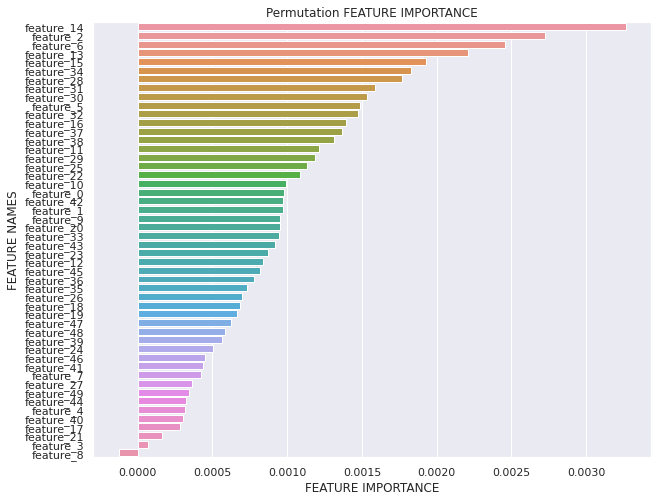

In [19]:
importance = permutation_importance(model, x_valid, y_valid, scoring='neg_log_loss', n_jobs=6, random_state=27)
top_features = plot_feature_importance(importance['importances_mean'], x_valid.columns, 'Permutation')

In [21]:
top_features[-2:]

['feature_3', 'feature_8']

In [ ]:
feature_8

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)

In [ ]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])